`python3 -m pip install -U pandas plotly nbformat`

`pip install "https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip"`

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np

from etl import get_dfts, get_mag_phase_mx, get_metadata, get_most_resonant, get_pcms, get_pcvs, test_dict_keys, \
  get_correlations, make_feature_vectors, get_metric, get_most_resonant_penta_dia

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from utils import get_coeff

from wavescapes.color import circular_hue

c:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Settings

In [2]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data'
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = False

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 82 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'n_onsets', 'TimeSig', 'KeySig', 'label_count',
       'composer', 'workTitle', 'movementNumber', 'movementTitle',
       'workNumber', 'poet', 'lyricist', 'arranger', 'copyright',
       'creationDate', 'mscVersion', 'platform', 'source', 'translator',
       'musescore', 'ambitus', 'comment', 'comments', 'composed_end',
       'composed_start', 'originalFormat', 'pdf', 'staff_1_ambitus',
       'staff_1_instrument', 'staff_2_ambitus', 'staff_2_instrument',
       'staff_3_ambitus', 'staff_3_instrument', 'transcriber', 'typesetter',
       'year', 'median_recording', 'qb_per_minute', 'sounding_notes_per_qb',
       'sounding_notes_per_minute'],
      dtype='object')

#### Columns for ordinal plots

Creating a column `years_ordinal` that represents the year of publication as a range of years in which Debussy composed.

Also creating a column `years_periods` in which the years of publication are grouped into three periods.

Periods:
- 1880-1892
- 1893-1912
- 1913-1917

src: the cambridge companion to Debussy (the phases years are not consistent accross all sources)

In [4]:
years_ordinal = {val:idx for idx, val in enumerate(np.sort(metadata.year.unique()))}
metadata['years_ordinal'] = metadata.year.apply(lambda x: years_ordinal[x])

In [5]:
years_periods = {}

for idx, val in enumerate(np.sort(metadata.year.unique())):
    if val < 1893:
        years_periods[val] = 0
    elif val < 1913:
        years_periods[val] = 1
    else:
        years_periods[val] = 2

metadata['years_periods'] = metadata.year.fillna(1880.0).apply(lambda x: years_periods[x])
metadata.years_ordinal.head(1),metadata.years_periods.head(1) 

(fnames
 l000_etude    18
 Name: years_ordinal, dtype: int64,
 fnames
 l000_etude    2
 Name: years_periods, dtype: int64)

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [6]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [7]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [8]:
pcvs = get_pcvs(DEBUSSY_REPO, pandas=True)
test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Found matrices for all files listed in metadata.tsv.


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0
"[1.0, 2.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[2.0, 3.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[3.0, 4.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[4.0, 5.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0


## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [9]:
pcms = get_pcms(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 12)

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [10]:
dfts = get_dfts(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 7)

You can view the 7 complex numbers as magnitude-phase pairs

In [11]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

array([[ 2.  ,  0.  ],
       [ 1.05,  1.98],
       [ 1.36, -2.31],
       [ 1.38,  0.25],
       [ 1.04,  1.81],
       [ 1.69, -1.82],
       [ 1.33,  0.  ]])

or even as strings where the numbers are rounded and angles are shown in degrees:

In [12]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.38+346°'],
       ['1.04+256°'],
       ['1.69+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

In [13]:
norm_params = ('0c', True)
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(mag_phase_mx_dict, metadata)
mag_phase_mx_dict[EXAMPLE_FNAME].shape


Found matrices for all files listed in metadata.tsv.


(284, 284, 6, 2)

In [14]:
mpm = mag_phase_mx_dict[EXAMPLE_FNAME]
colors = circular_hue(mpm[...,1,:], output_rgba=True, ignore_phase=True)
colors.shape

(284, 284)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

In [15]:
mag_phase_mx_dict[EXAMPLE_FNAME][0]

array([[[ 5.38214271e-01,  1.97790855e+00],
        [ 7.49750250e-01, -2.30792065e+00],
        [ 8.33166833e-01,  2.45331397e-01],
        [ 7.49750250e-01,  1.81282734e+00],
        [ 8.71880604e-01, -1.82039166e+00],
        [ 6.66333666e-01,  8.32251143e-17]],

       [[ 4.44424363e-01,  2.51616207e+00],
        [ 4.99500500e-01, -2.25090725e+00],
        [ 6.66333666e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.76042734e+00],
        [ 7.72101656e-01, -1.65477615e+00],
        [ 3.32667333e-01,  8.33500769e-17]],

       [[ 4.10683603e-01, -2.09439510e+00],
        [ 1.66666667e-01,  2.09439510e+00],
        [ 3.33333333e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.04719755e+00],
        [ 7.44016936e-01, -1.04719755e+00],
        [ 3.33333333e-01, -3.14159265e+00]],

       ...,

       [[ 1.78632795e-01, -2.61799388e-01],
        [ 3.33333333e-01, -2.09439510e+00],
        [ 1.00000000e+00,  4.63647609e-01],
        [ 1.00000000e+00,  5.23598776e-01],
        [ 6.6

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [16]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict, )
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

c:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

## Loading major, minor, and tritone correlations

This cell loads pickled matrices. To re-compute correlations from pitch-class matrices, use `get_maj_min_coeffs()` for major and minor correlations and `get_ttms()` for tritone-ness matrices.

In [17]:
correl_dict = get_correlations(DATA_FOLDER, long=LONG_FORMAT)
test_dict_keys(correl_dict, metadata)
correl_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [18]:
norm_params = ('0c', True)
ninefold_dict = make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 9)

### Separating pentatonic from diatonic

In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

ground_truth_train = pd.read_csv('full_groundtruth_train.csv')
penta_dia = ground_truth_train[ground_truth_train['structure'].isin(['penta', 'majmin'])]

X_cols = ['coeff1', 'coeff2', 'coeff3', 'coeff4', 'coeff5', 'coeff6', 'major', 'minor', 'tritone']
X_train, X_test, y_train, y_test = train_test_split(
    penta_dia[X_cols], penta_dia['diatonic'], test_size=0.33, random_state=42
    )

clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
print(clf.score(X_test, y_test))

max_coeffs_penta, max_mags_penta, inv_entropies_penta = get_most_resonant_penta_dia(mag_phase_mx_dict, ninefold_dict, clf)
np.column_stack((max_coeffs_penta[EXAMPLE_FNAME][:3],
max_mags_penta[EXAMPLE_FNAME][:3],
inv_entropies_penta[EXAMPLE_FNAME][:3]))

0.9402254249815225


C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

# Metrics

In this section, a dataframe containing all metrics is compiled. Optional plots and tests can be done by adjusting the parameters of the wrapper function `get_metric` that can be found in `etl.py`. 

In [61]:
metadata_metrics = metadata.copy()
#metadata_metrics = pd.read_csv('metrics.csv').set_index('fname')


## Center of mass

Computing the center of mass of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the vertical center of mass as a fraction of the height of the wavescape.

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.2116112483272087, 0.24315489829019235, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,sounding_notes_per_qb,sounding_notes_per_minute,years_ordinal,years_periods,center_of_mass_1,center_of_mass_2,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,3.377641,211.169938,18,2,0.266001,0.211611,0.243155,0.22164,0.285275,0.214474


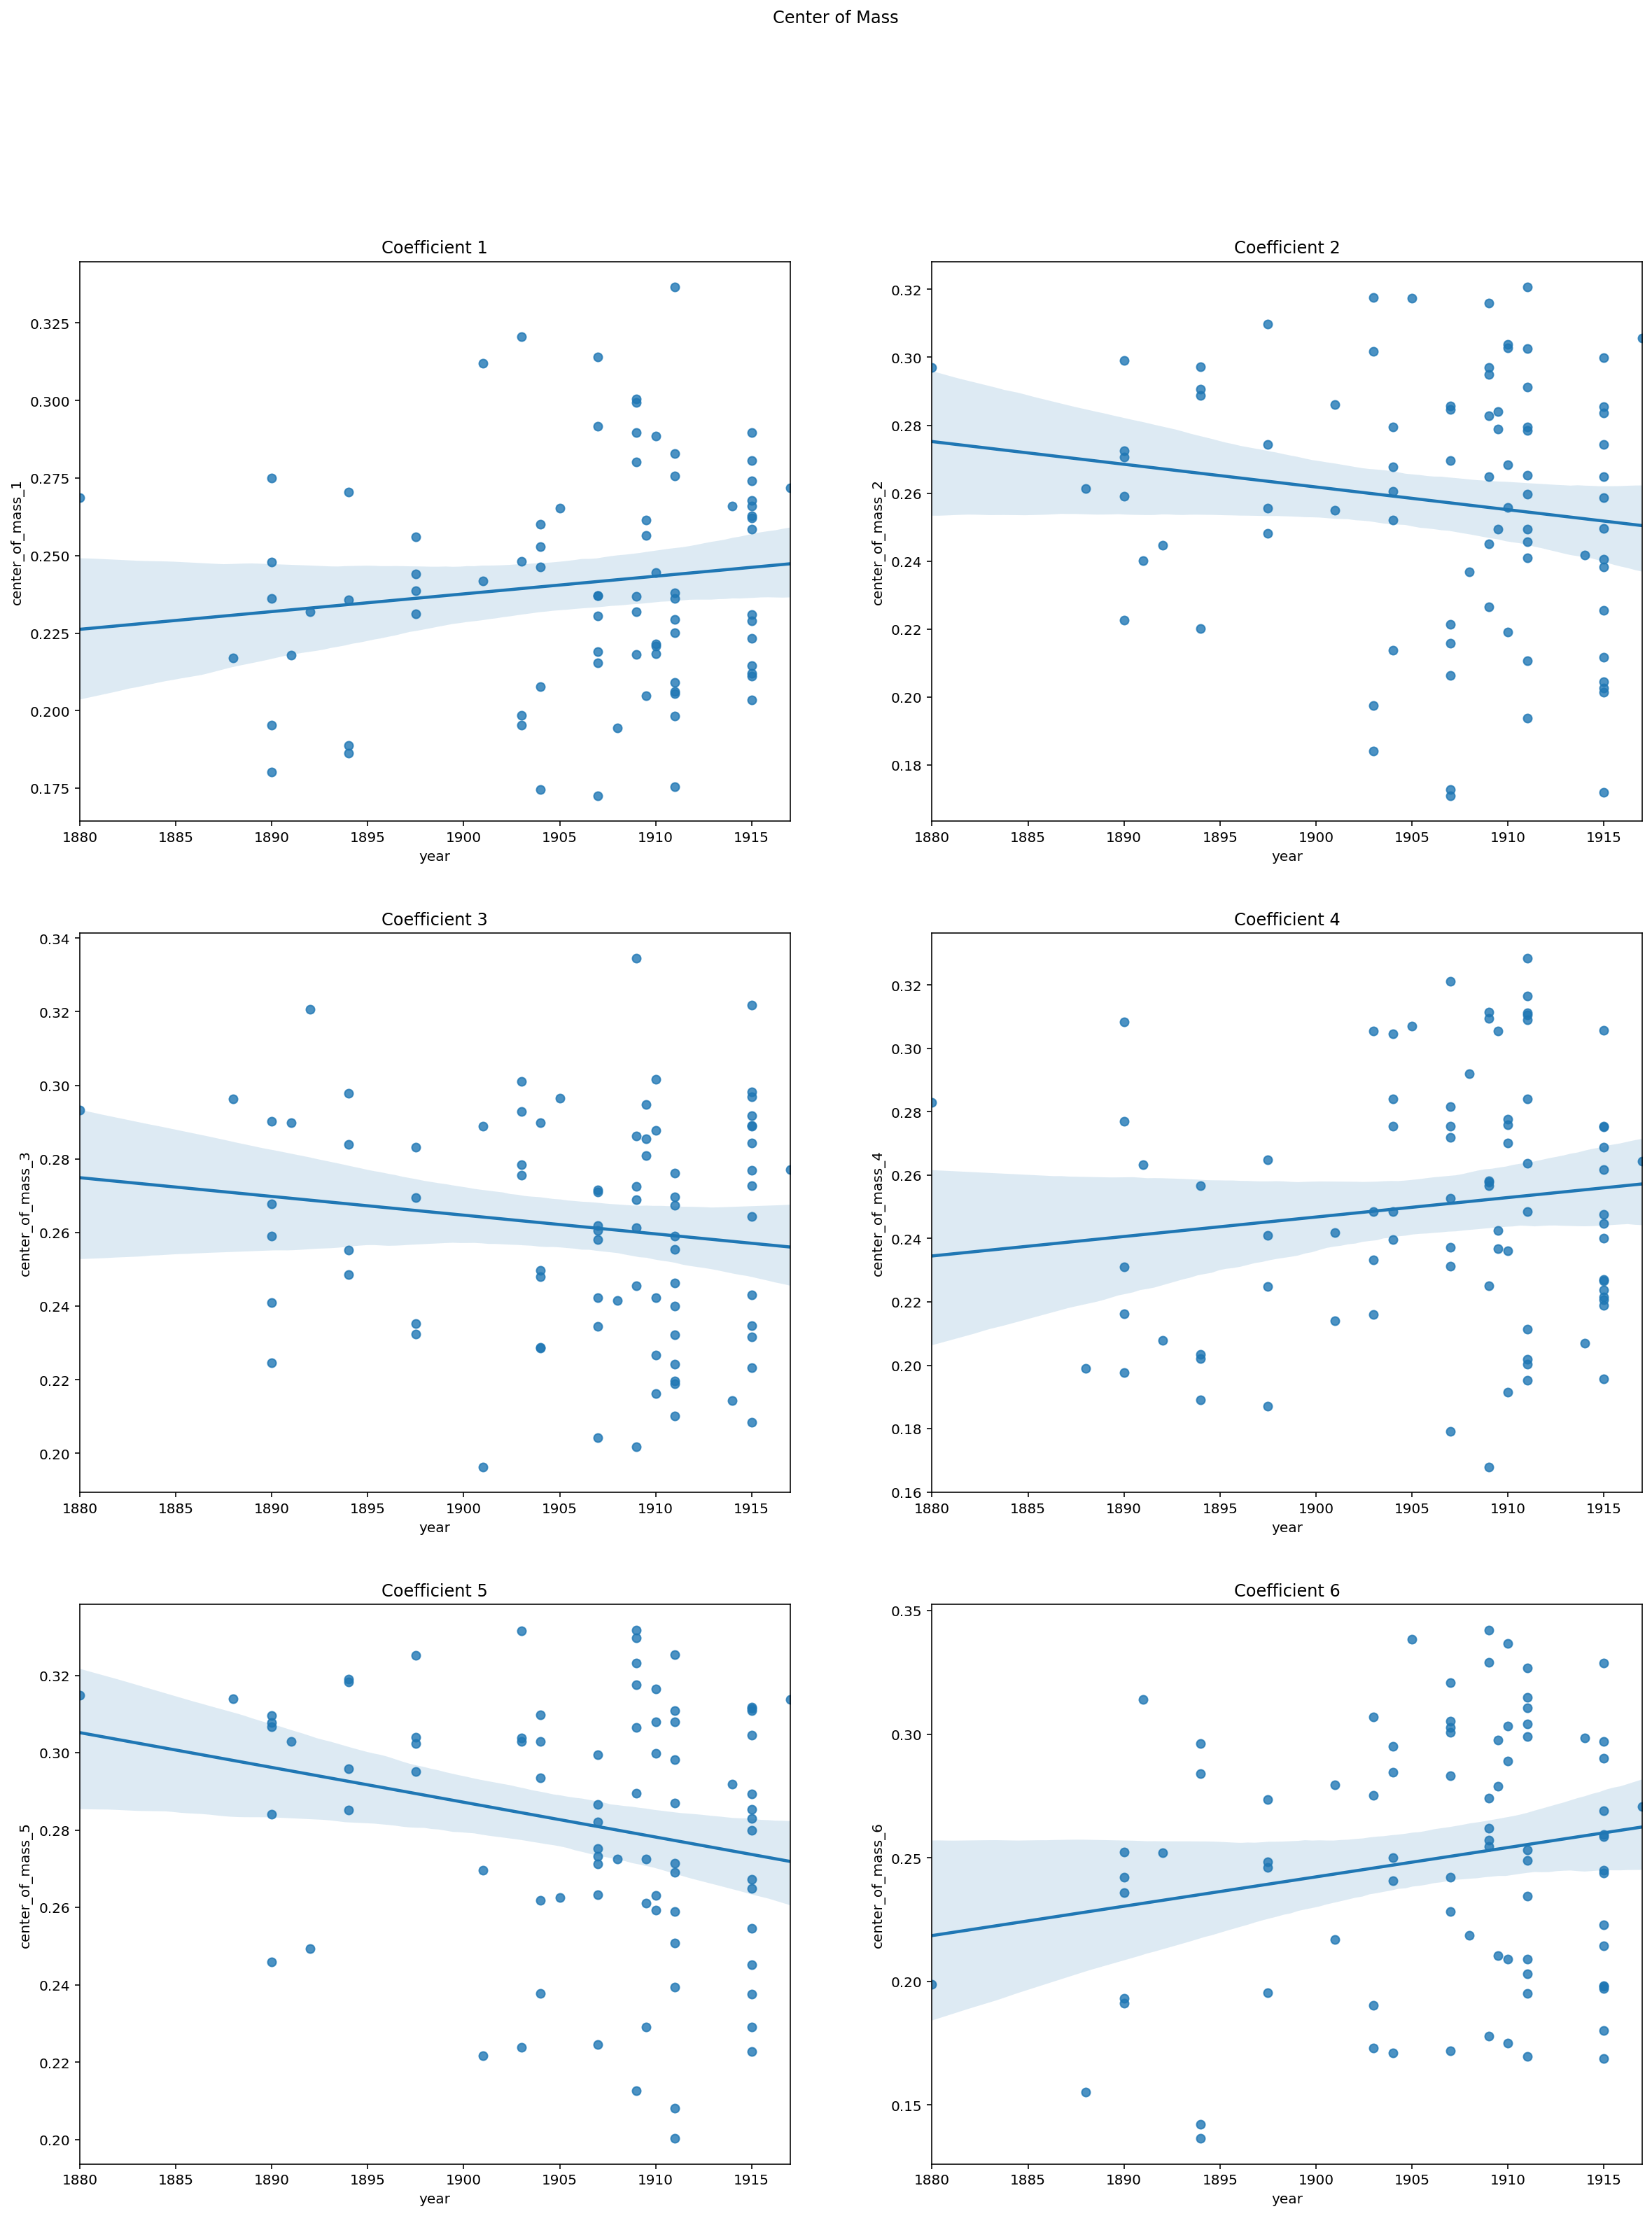

In [33]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict, 
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass')
metadata_metrics.head(1)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.2116112483272087, 0.24315489829019235, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


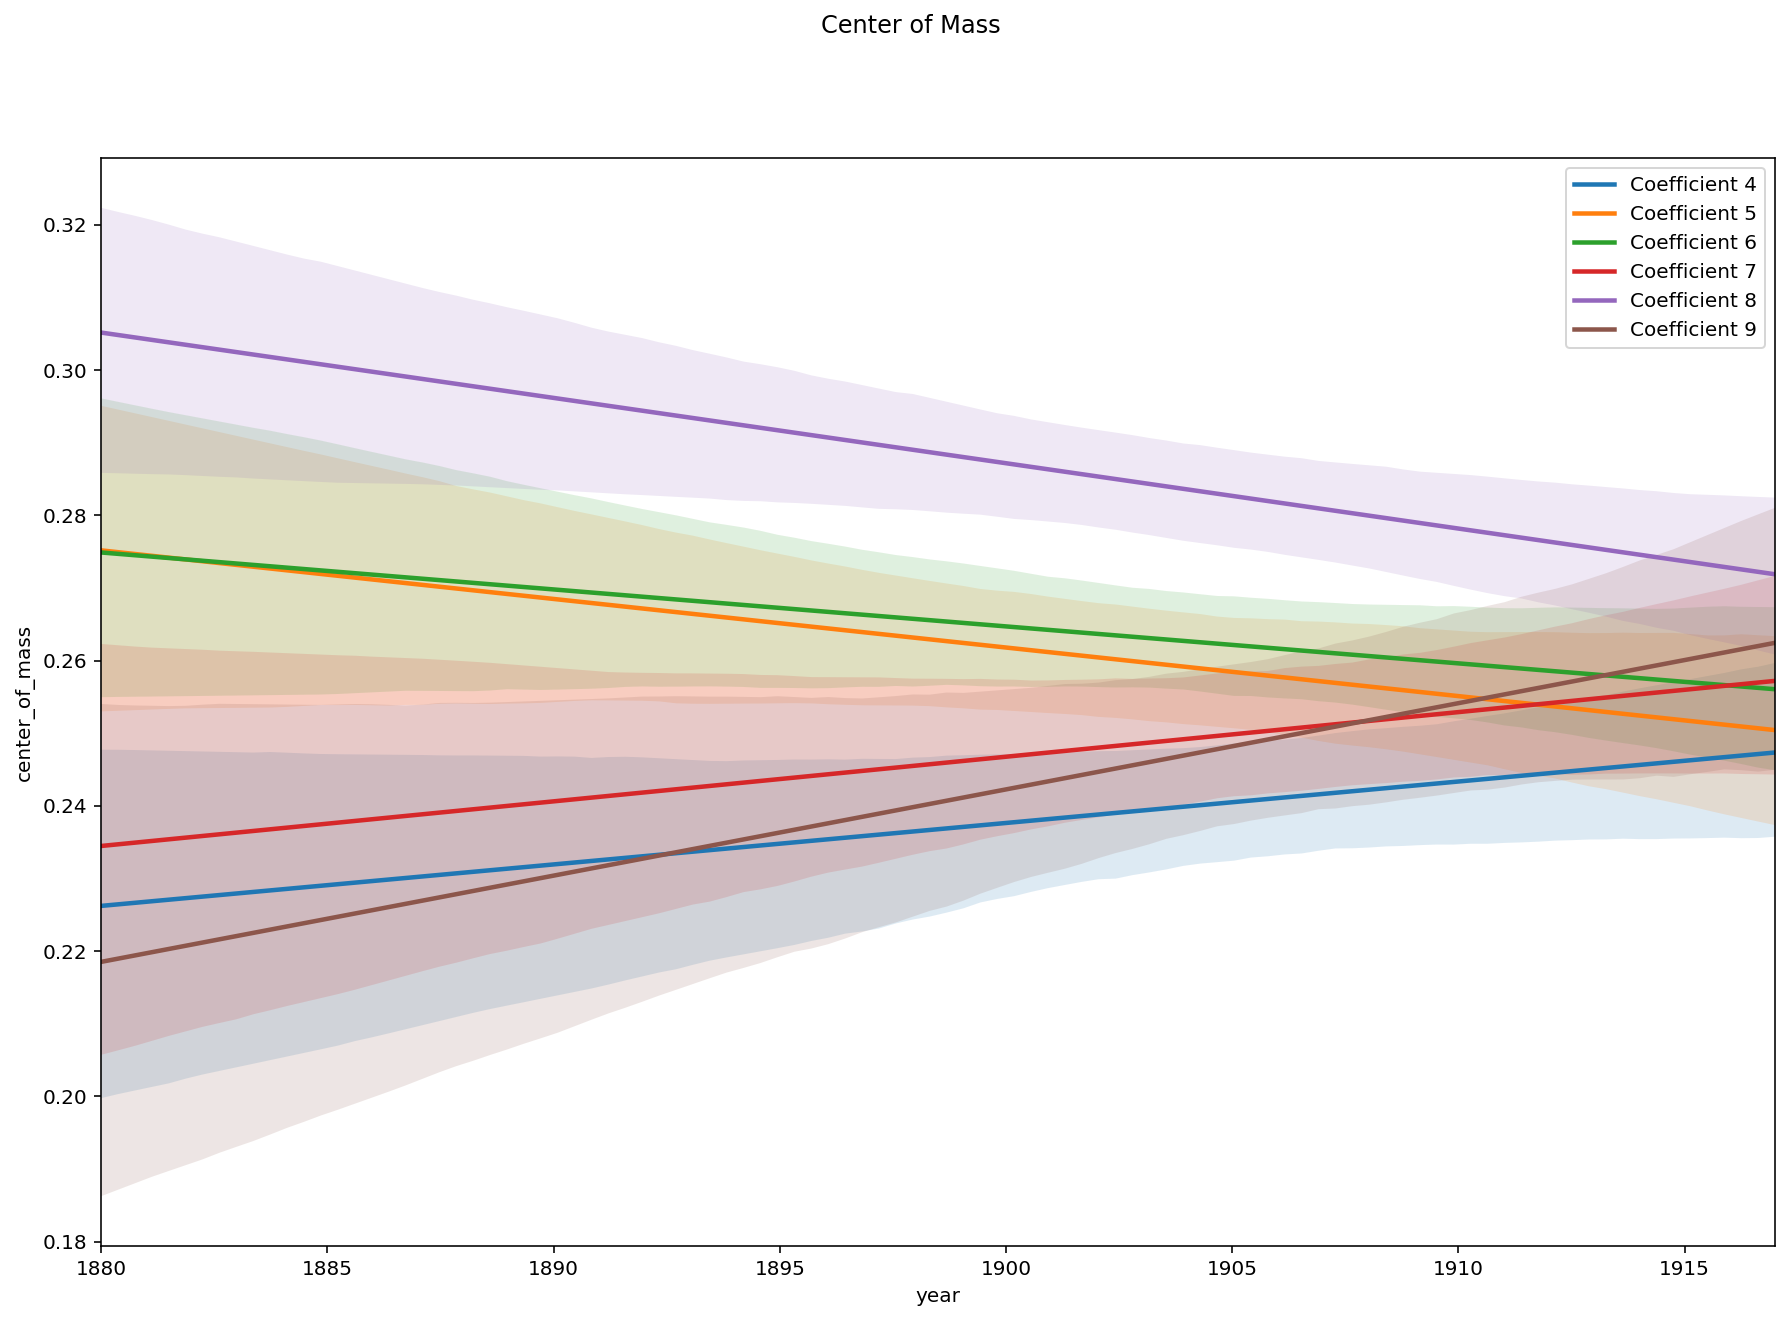

In [21]:
# trying out some options of the function
# 1 unified plot
metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass',
                              unified=True)


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.2116112483272087, 0.24315489829019235, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


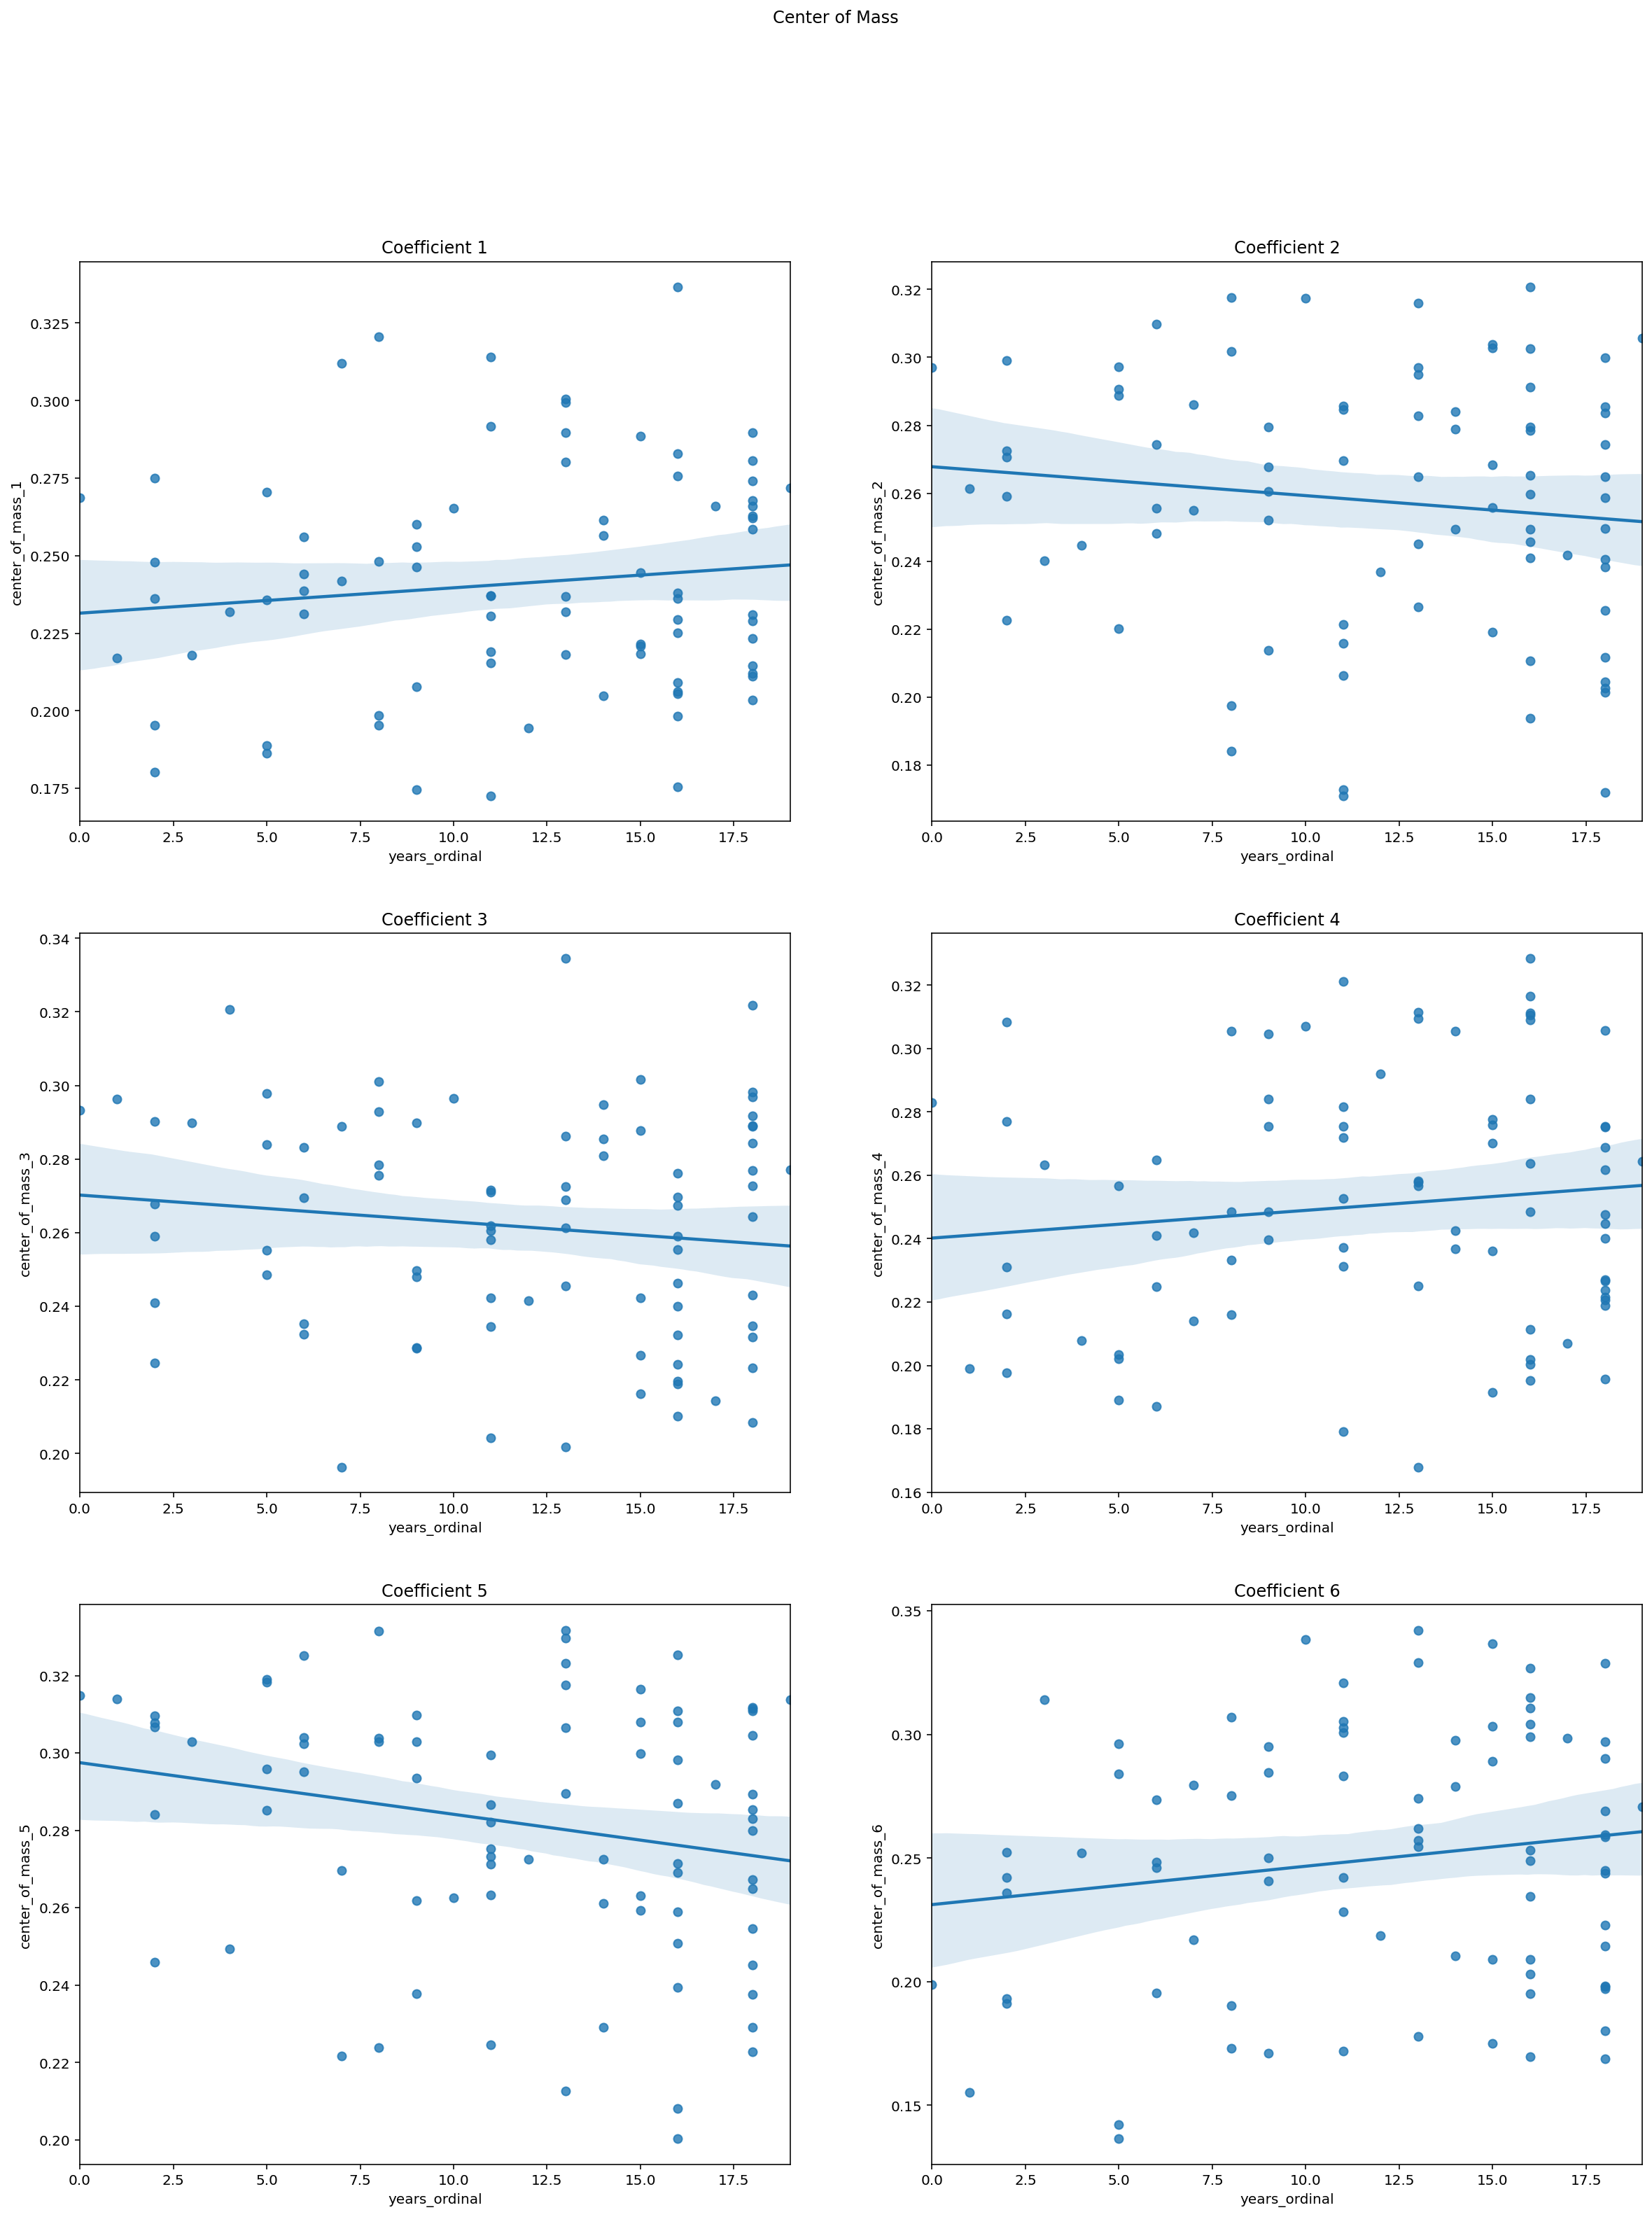

In [22]:
# 2 using ordinal years
metadata_metrics = get_metric('center_of_mass', metadata_metrics,
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True,
                              show_plot=True, save_name='center_of_mass', title='Center of Mass',
                              ordinal=True, ordinal_col='years_ordinal')

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.2116112483272087, 0.24315489829019235, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


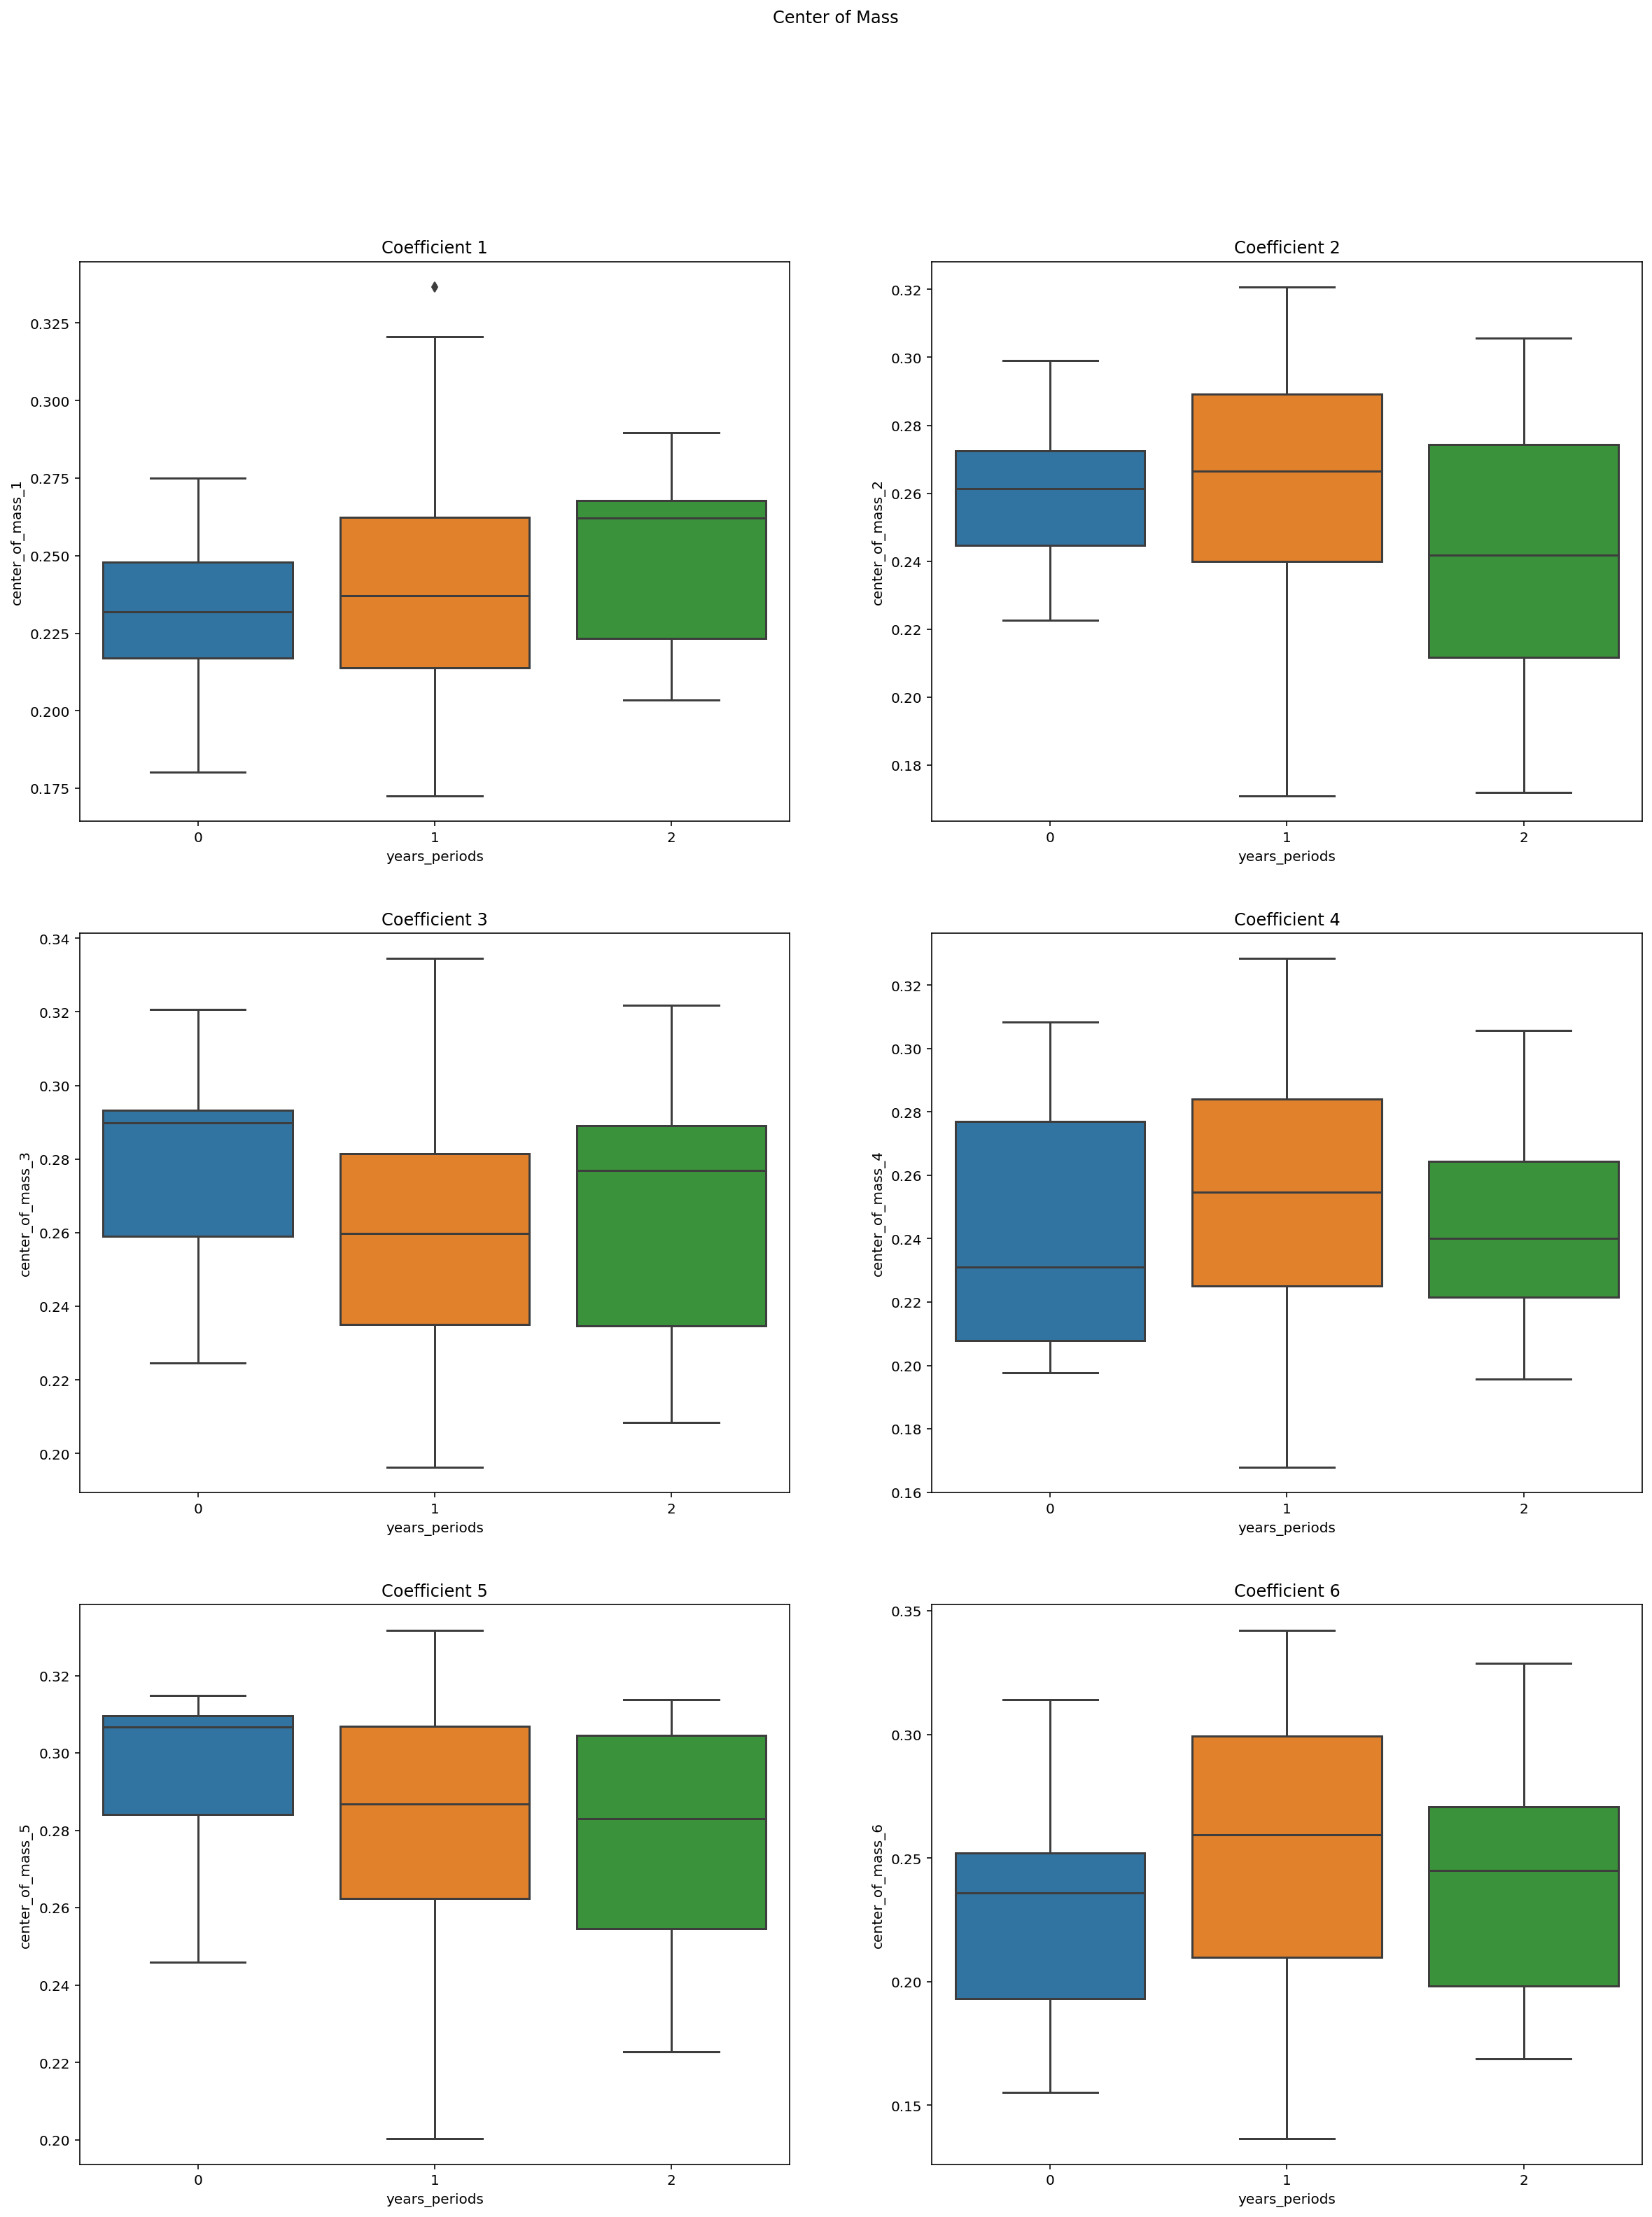

In [23]:
# boxplot version with ordinal column
metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass', 
                              boxplot=True, ordinal=True, ordinal_col='years_periods')

In [24]:
# 4. testing option
metadata_metrics = get_metric('center_of_mass', metadata_metrics,
                              mag_phase_mx_dict=mag_phase_mx_dict, cols=cols,
                              store_matrix=True, testing=True)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.2116112483272087, 0.24315489829019235, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]
testing results
                            OLS Regression Results                            
Dep. Variable:       center_of_mass_4   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8020
Date:                Thu, 25 Aug 2022   Prob (F-statistic):              0.452
Time:                        17:04:12   Log-Likelihood:                -115.53
No. Observations:                  82   AIC:                             237.1
Df Residuals:                      79   BIC:                             244.3
Df Model:                           2                                         
Covariance Type:            nonrobust

# Mean Resonance

Computing the mean resonance of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the magnitude resonance of the wavescape for each coefficient.

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.05352486 0.0653218  0.10388608 0.15191741 0.15174701 0.06172378]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6,mean_resonances_1,mean_resonances_2,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.243155,0.22164,0.285275,0.214474,0.053525,0.065322,0.103886,0.151917,0.151747,0.061724


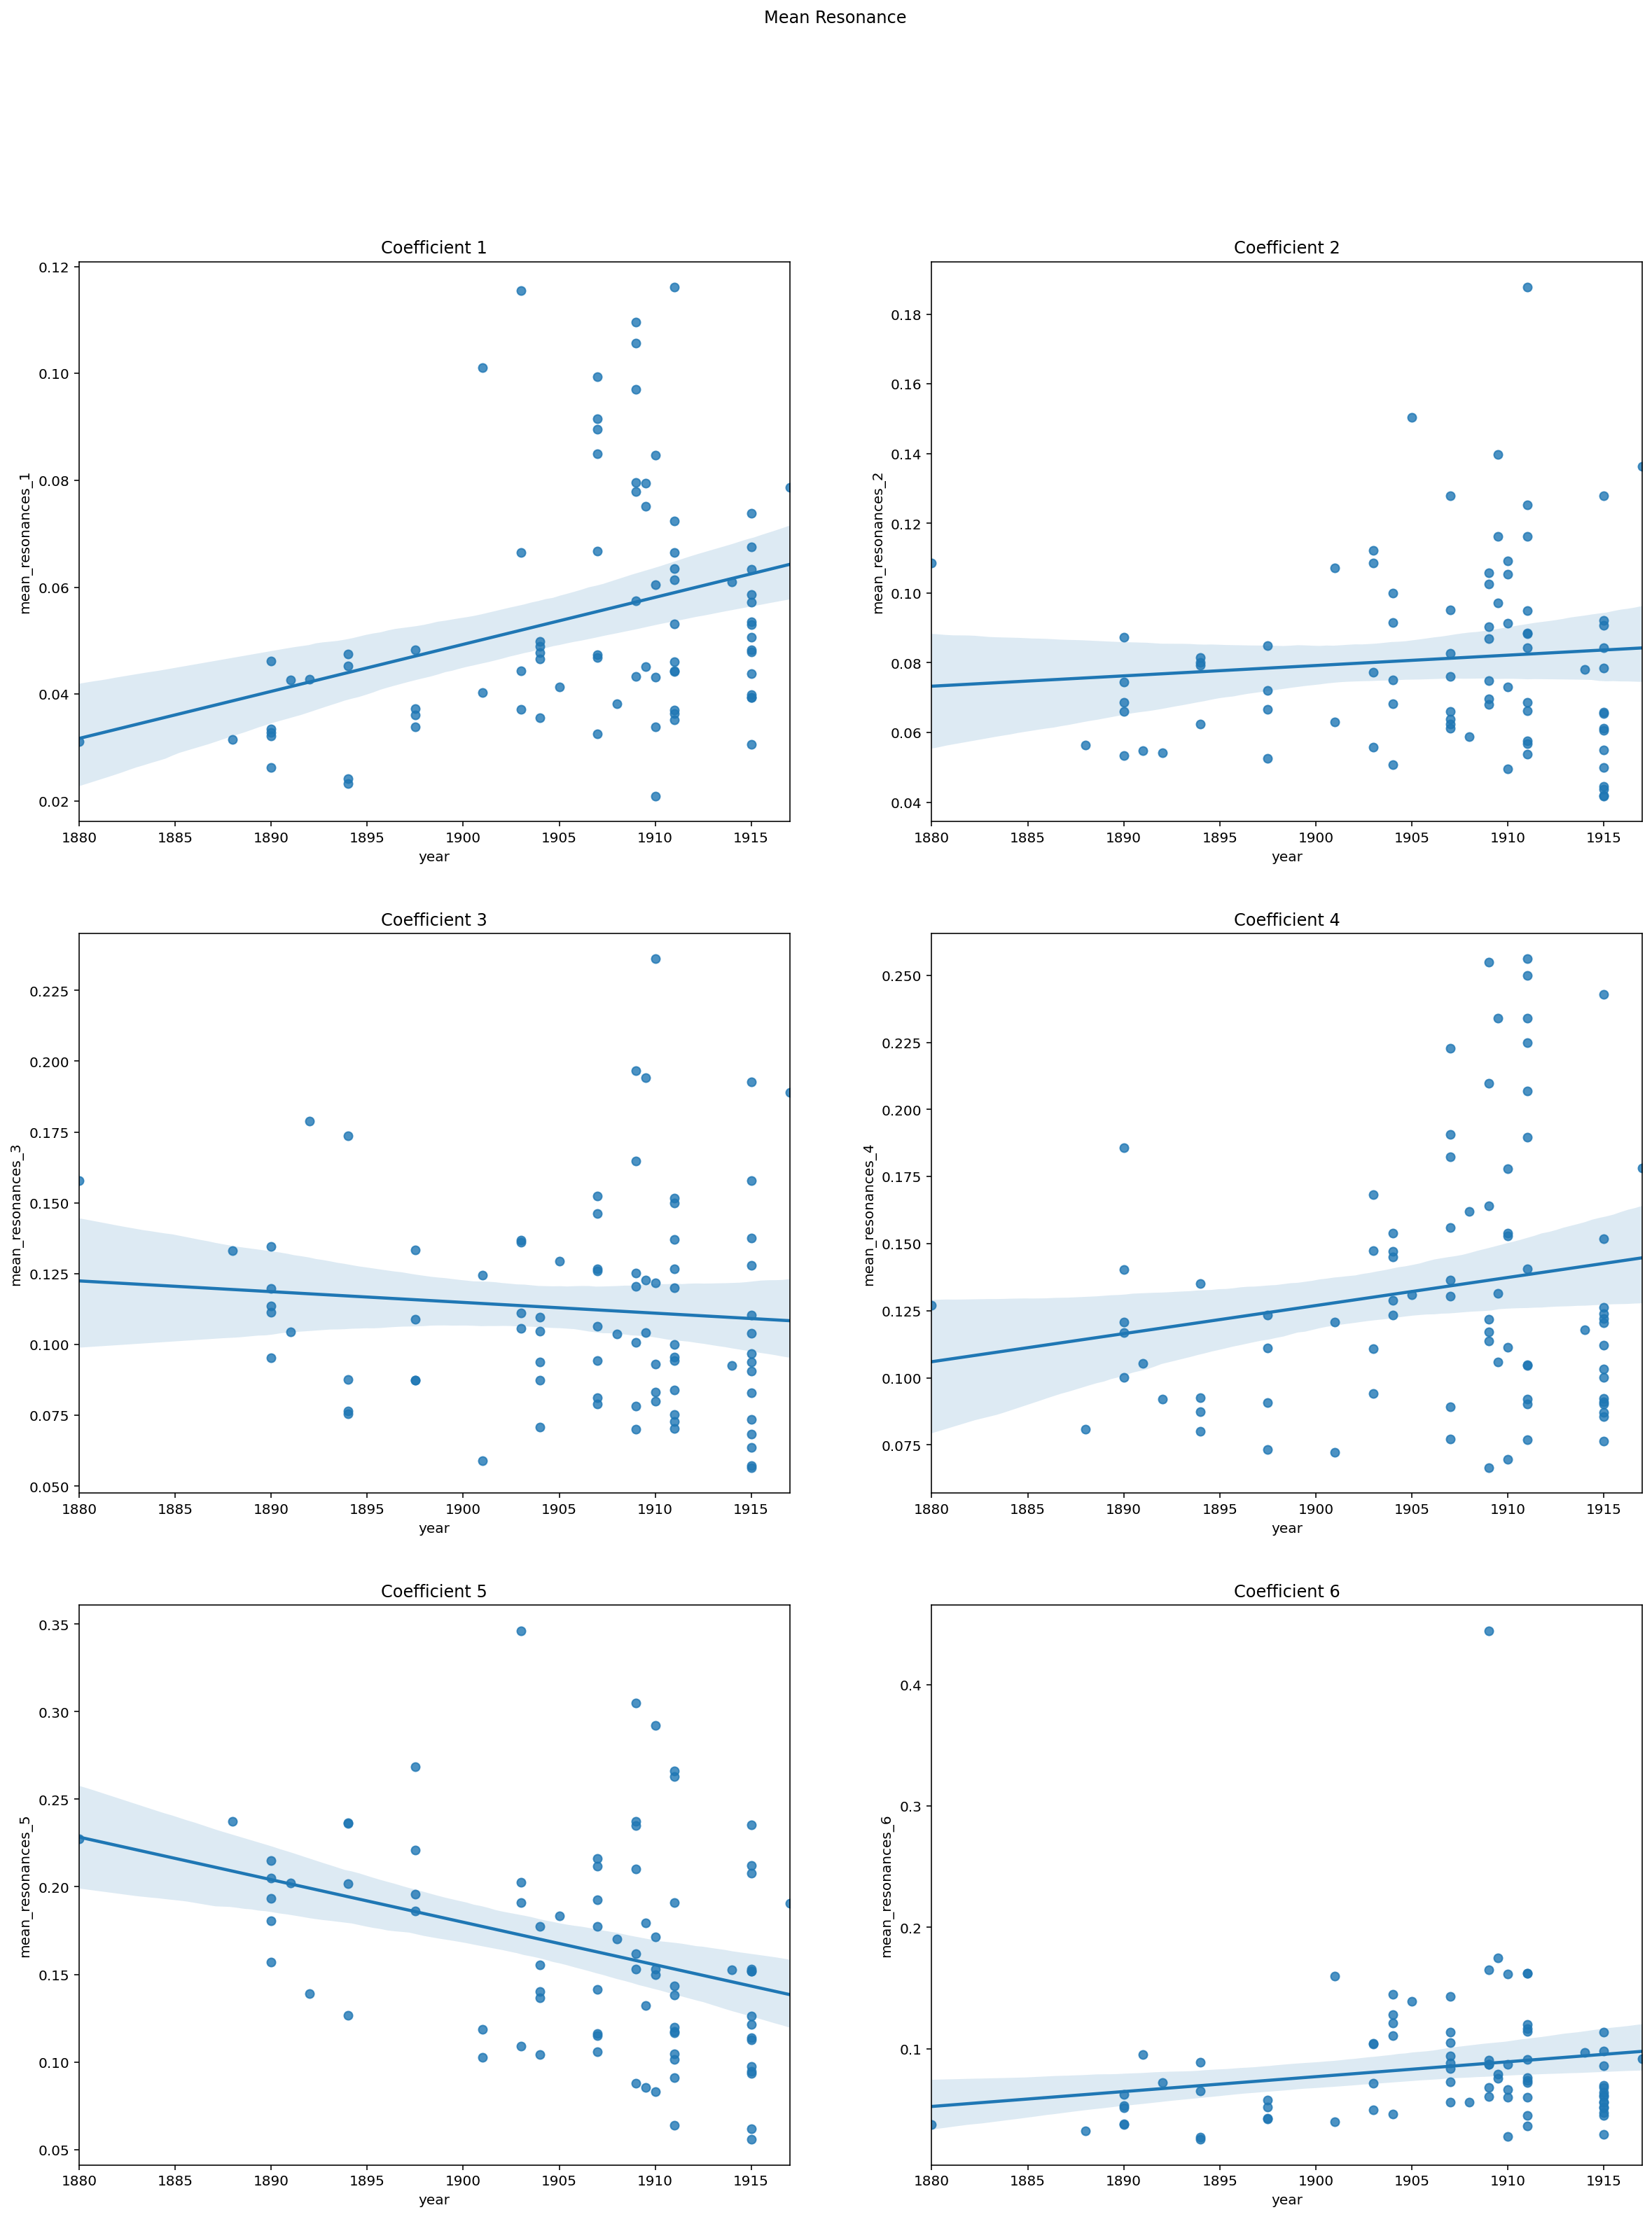

In [85]:
cols = [f"mean_resonances_{i}" for i in range(1,7)]

metadata_metrics = get_metric('mean_resonance', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='mean_resonances', title='Mean Resonance')
metadata_metrics.head(1)

In [25]:
# per period ordinal plot
metadata_metrics = get_metric('mean_resonance', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=False, testing=True, save_name='mean_resonance_per_period', title='Mean Resonance per Period', boxplot=True,
                              ordinal=True, ordinal_col='years_periods')

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.05352486 0.0653218  0.10388608 0.15191741 0.15174701 0.06172378]
testing results
                            OLS Regression Results                            
Dep. Variable:       center_of_mass_4   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.650
Date:                Thu, 25 Aug 2022   Prob (F-statistic):             0.0769
Time:                        17:05:01   Log-Likelihood:                -113.69
No. Observations:                  82   AIC:                             233.4
Df Residuals:                      79   BIC:                             240.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
              

# Center of Mass 
#### only on most resonant coefficients

In [143]:
metadata_metrics = metadata.copy()

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.37624648e-06 3.14853562e-05 1.31722347e-02 2.53584479e-02
 5.97289582e-02 1.13074520e-04]
        fname  length_qb    year  last_mc          variable     value
0  l000_etude      284.0  1915.0       73  center_of_mass_1  0.000001
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     23.77
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           1.32e-41
Time:                        15:46:01   Log-Likelihood:                 993.17
No. Observations:                 492   AIC:                            -1960.
Df Residuals:                     479   BIC:                            -1906.
Df Mode

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,sounding_notes_per_qb,sounding_notes_per_minute,years_ordinal,years_periods,center_of_mass_1,center_of_mass_2,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,3.377641,211.169938,18,2,0.000001,0.000031,0.013172,0.025358,0.059729,0.000113


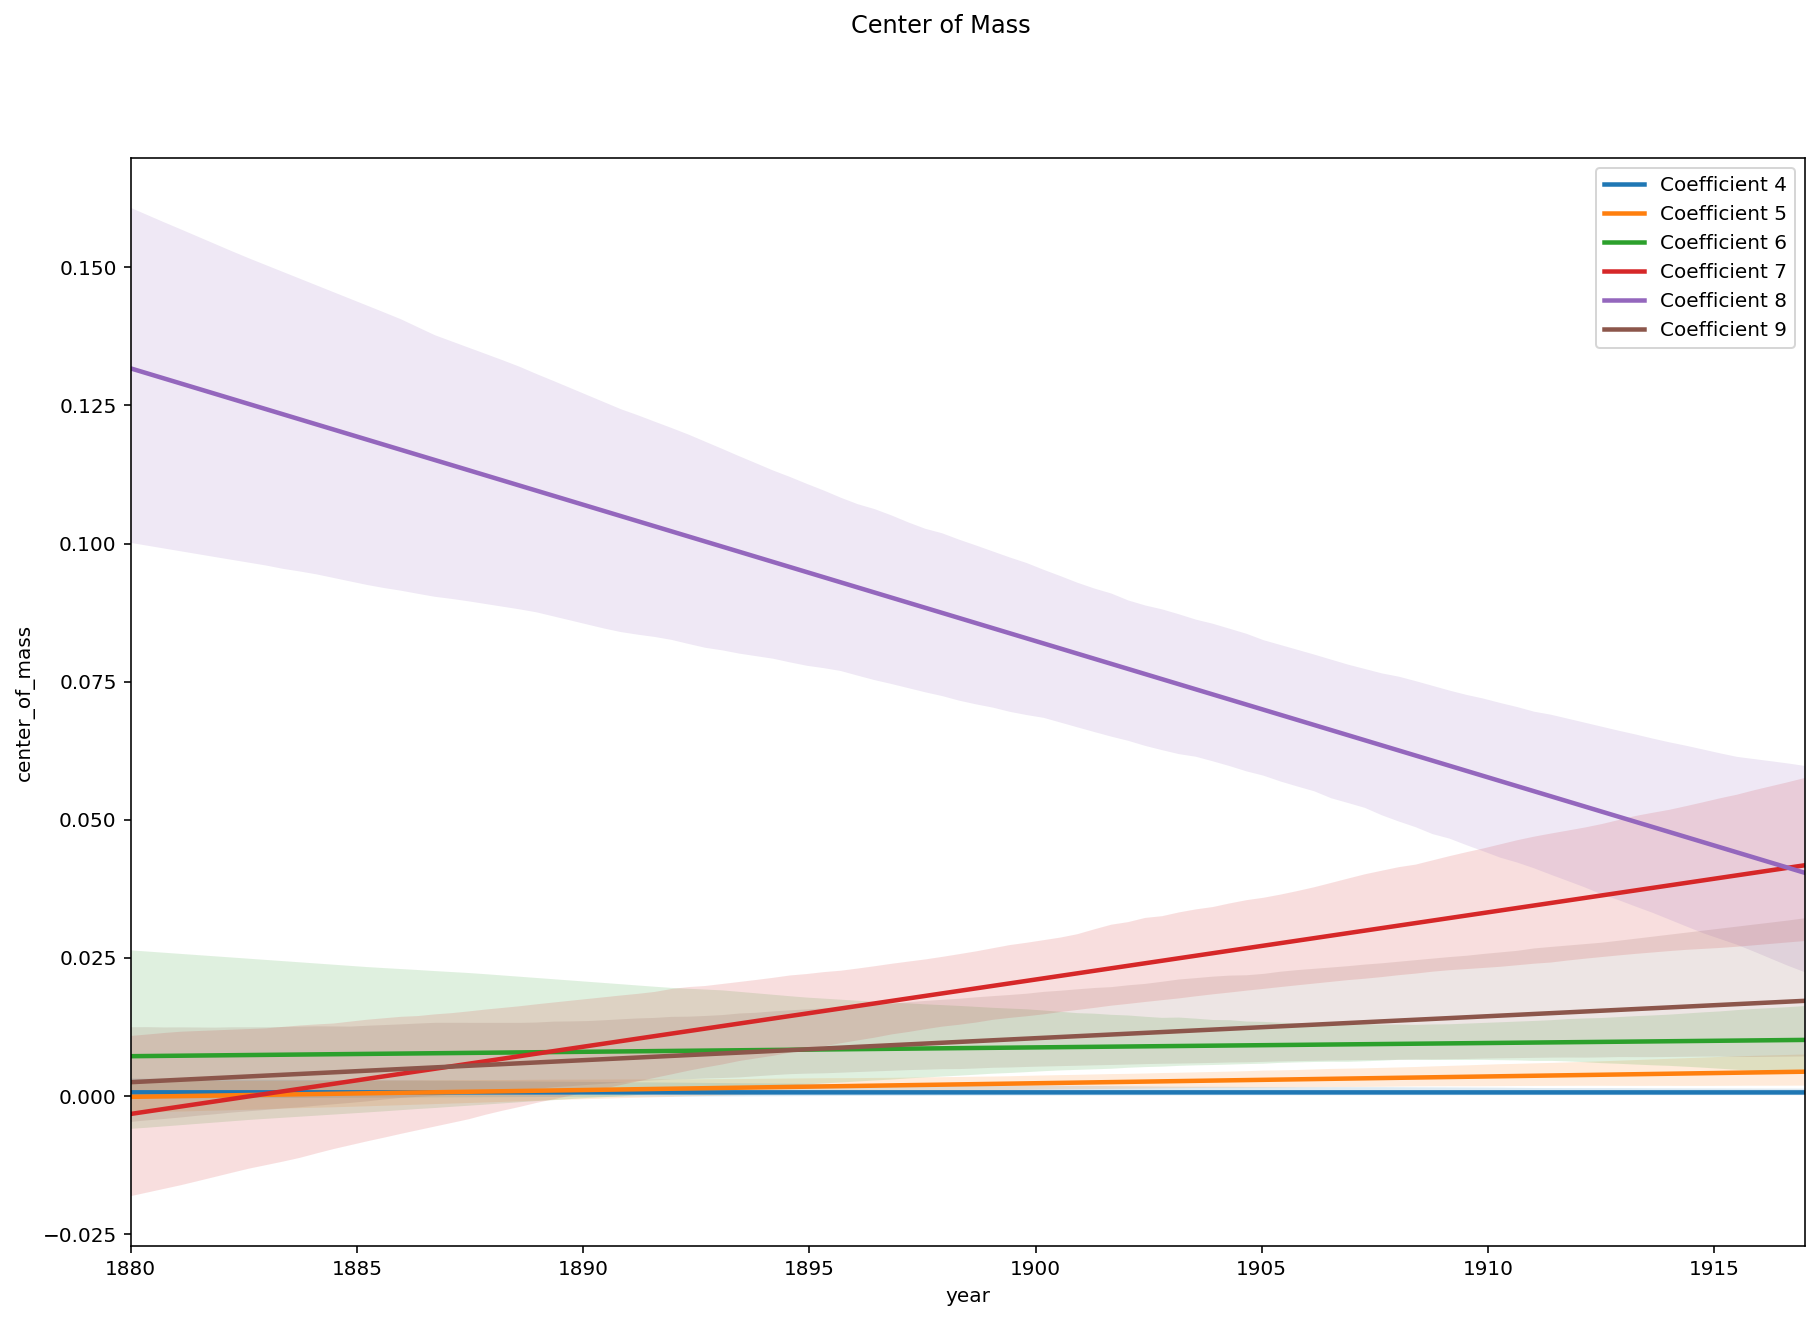

In [146]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = get_metric('center_of_mass_2', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, testing=True, unified=True,
                              show_plot=True, save_name='center_of_mass', title='Center of Mass')
metadata_metrics.head(1)

# Moment of Inertia

Moment of inertia of coefficient $n$ in the summary wavescape: $I(n)=1/N \sum_{i \in S(n)} w_i y_i^2$, where N is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient n is the most prominent among the six), $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, and $y_i$ is the vertical coordinate of the $i$-th node in the summary wavescape


6
Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.90132927e-08 3.42032095e-06 4.49496960e-03 6.55152625e-03
 3.26146744e-02 2.60299197e-05]
        fname  length_qb    year  last_mc              variable         value
0  l000_etude      284.0  1915.0       73  moments_of_inertia_1  1.901329e-08
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     21.35
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           1.03e-37
Time:                        15:46:43   Log-Likelihood:                 1314.0
No. Observations:                 492   AIC:                            -2602.
Df Residuals:                     479   BIC:                        

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.013172,0.025358,0.059729,0.000113,1.901329e-08,0.000003,0.004495,0.006552,0.032615,0.000026


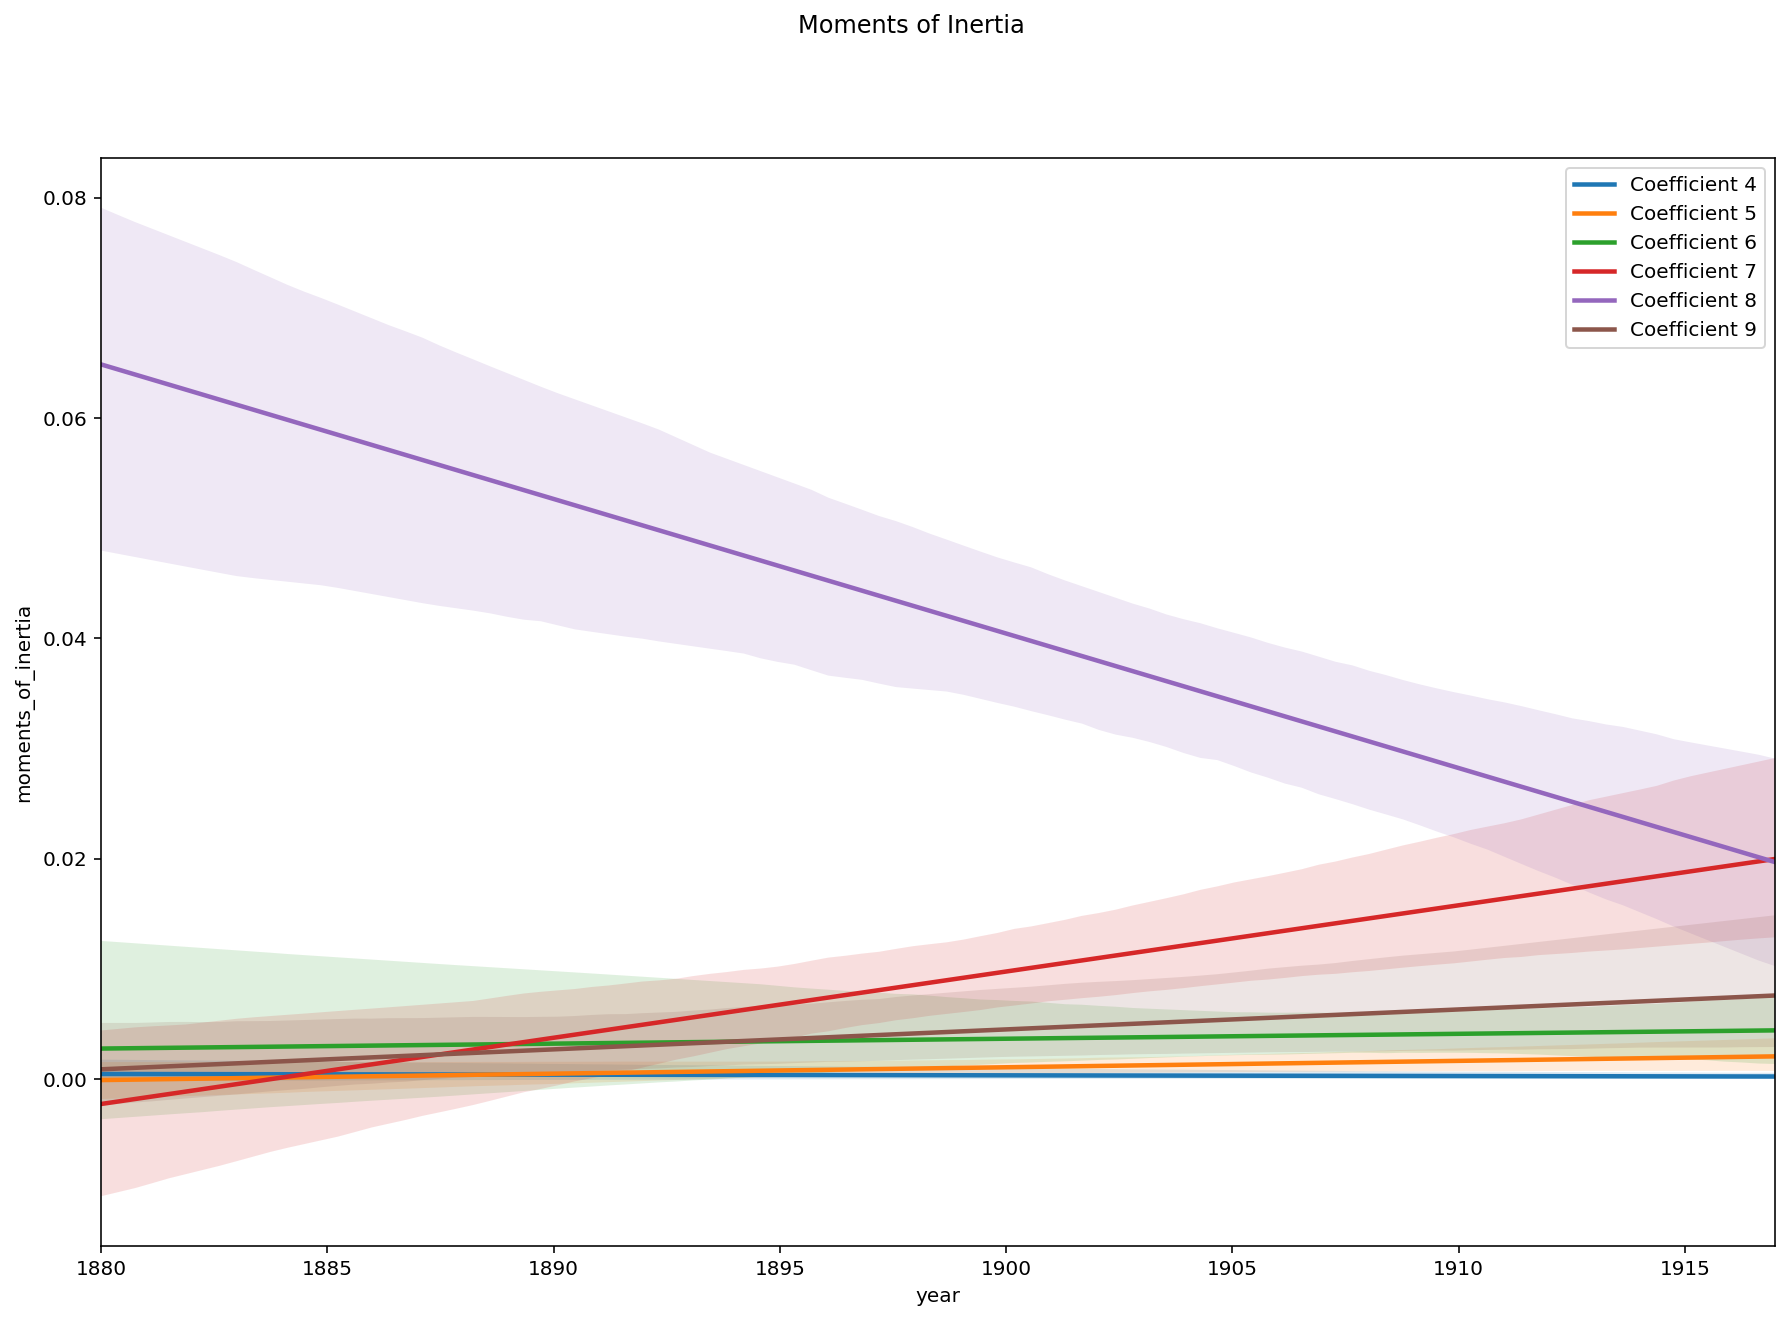

In [147]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]
print(len(cols))
metadata_metrics = get_metric('moment_of_inertia', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              max_mags=max_mags,
                              cols=cols, store_matrix=True,
                              testing=True, 
                              show_plot=True, save_name='moments_of_inertia', title='Moments of Inertia', unified=True)
metadata_metrics.head(1)

# Prevalence of each coefficient

Prevalence of coefficient $n$ in a piece: $W(n)=1/N \sum_{i \in S(n)} i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six).

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.99692521 0.00210772 0.15537592 0.32255505 0.51909343 0.00394267]
        fname  length_qb    year  last_mc                 variable     value
0  l000_etude      284.0  1915.0       73  percentage_resonances_1  0.996925
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     149.5
Date:                Tue, 30 Aug 2022   Prob (F-statistic):          2.41e-153
Time:                        15:48:02   Log-Likelihood:                 155.13
No. Observations:                 492   AIC:                            -284.3
Df Residuals:                     479   BIC:                            -229.7
Df Model:         

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.004495,0.006552,0.032615,0.000026,0.996925,0.002108,0.155376,0.322555,0.519093,0.003943


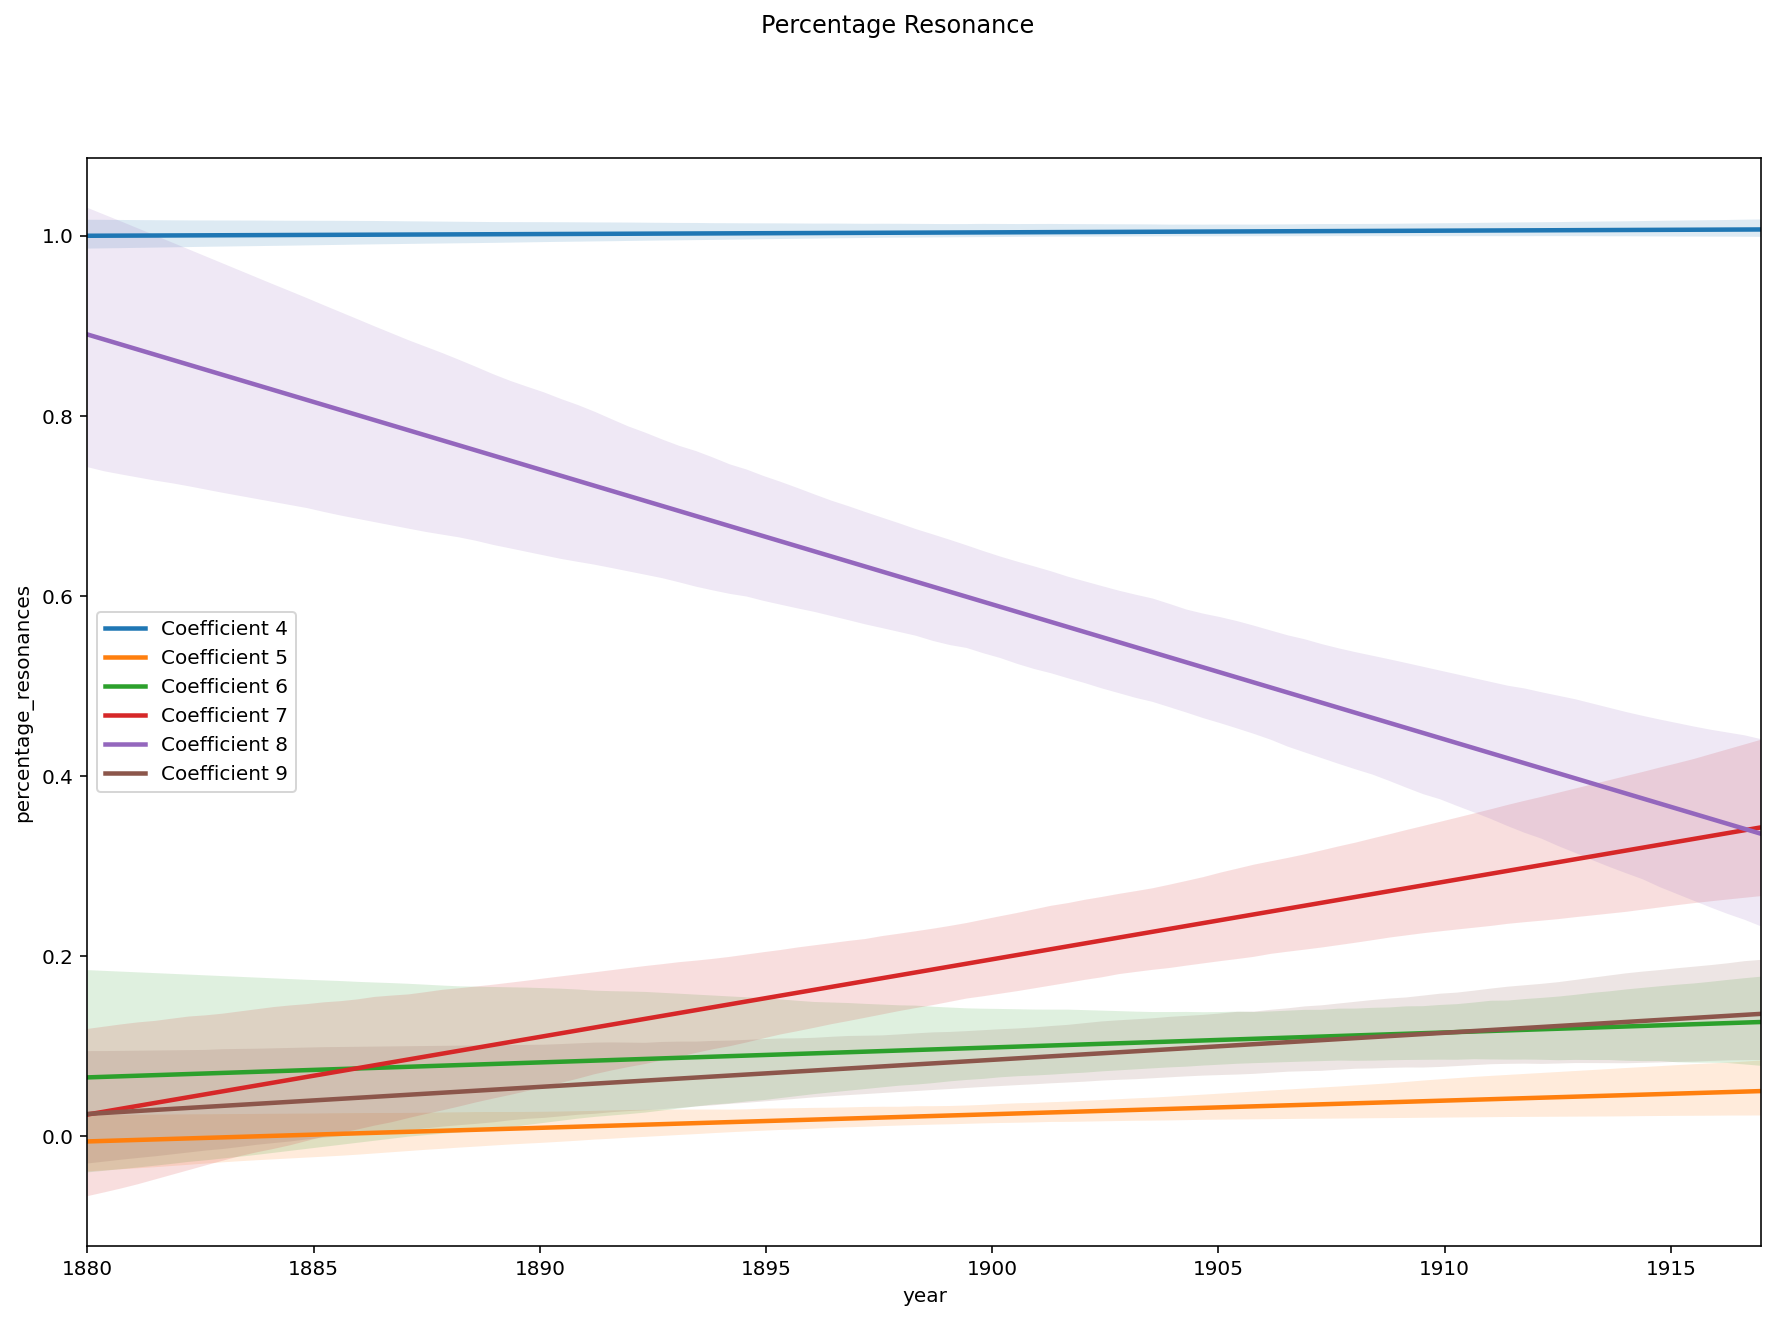

In [151]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, testing=True,
                              show_plot=True, save_name='percentage_resonance', title='Percentage Resonance', unified=True)
metadata_metrics.head(1)

In [152]:
# metadata_metrics = get_metric('percentage_resonance', metadata_metrics, 
#                               max_coeffs=max_coeffs,
#                               cols=cols, store_matrix=True, 
#                               show_plot=True, save_name='percentage_resonance_periods', title='Percentage Resonance (Periods)',  boxplot=True,
#                               ordinal=True, ordinal_col='years_periods')

In order to account for the certainty that a certain coefficient is actually the most resonance, we weigh the previous metric by entropy as follows: $W(n)=1/N \sum_{i \in S(n)} w_i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six), and $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, in this case, the entropy of $i$.



Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [3.68269427e-05 3.44656566e-04 3.62538535e-02 7.46800853e-02
 1.13474114e-01 5.84514693e-04]
        fname  length_qb    year  last_mc                         variable  \
0  l000_etude      284.0  1915.0       73  percentage_resonances_entropy_1   

      value  
0  0.000037  
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     27.34
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           5.91e-47
Time:                        15:48:07   Log-Likelihood:                 657.05
No. Observations:                 486   AIC:                            -1288.
Df Residuals:                     473   B

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.155376,0.322555,0.519093,0.003943,0.000037,0.000345,0.036254,0.07468,0.113474,0.000585


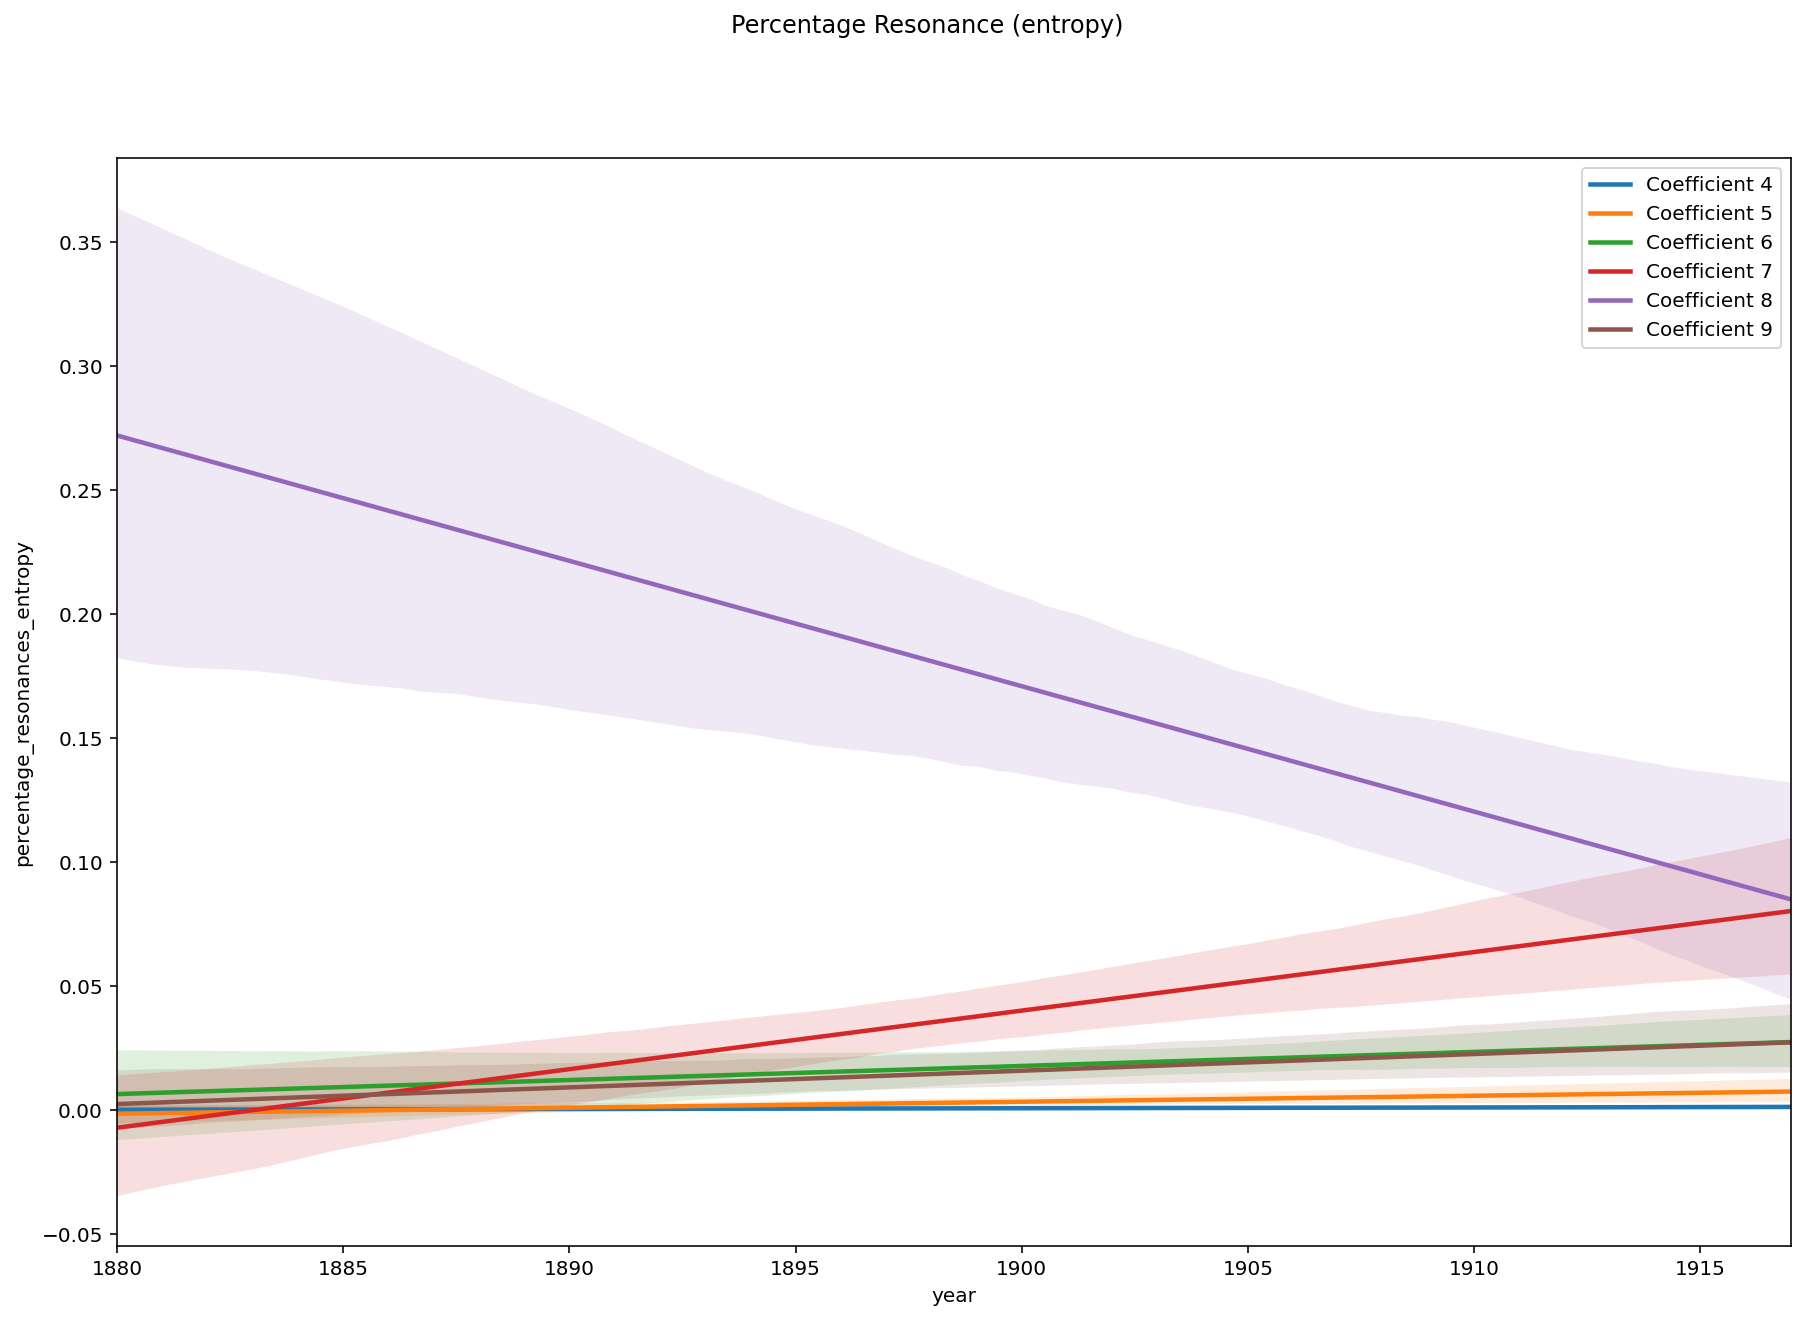

In [153]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              inv_entropies=inv_entropies,
                              cols=cols, store_matrix=True, 
                              testing=True,
                              show_plot=True, save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)', unified=True)
metadata_metrics.head(1)

In [103]:
# metadata_metrics = get_metric('percentage_resonance_entropy', metadata_metrics, 
#                               max_coeffs=max_coeffs,
#                               inv_entropies=inv_entropies,
#                               cols=cols, store_matrix=True, 
#                               show_plot=True, save_name='percentage_resonance_entropy_period', title='Percentage Resonance (entropy period)',  boxplot=True,
#                               ordinal=True, ordinal_col='years_periods')

In [104]:
#metadata_metrics.to_csv('results/results.csv')

In [3]:
import pandas as pd

metadata = pd.read_csv('results/metrics_melted (1).csv')
metadata.head()
metadata['value_com']


0      1.376246e-06
1      0.000000e+00
2      0.000000e+00
3      1.056985e-07
4      2.555637e-05
           ...     
487    8.857452e-03
488    5.074632e-05
489    3.189363e-04
490    1.155023e-04
491    2.814925e-03
Name: value_com, Length: 492, dtype: float64

# Measure Theoretic Entropy

Measure-theoretic entropy: Let $A={A_1,...,A_k}$ be a (finite) partition of a probability space $(X,P(X),)$: the entropy of the partition $A$ is defined as $H(A)= - \sum_{i} \mu(A_i) \log \mu(A_i)$. We can take $X$ as the support of the wavescape, $A$ as the set of the connected regions in the unified wavescape, and $\mu(Y)=(area-of-Y)/(area-of-X)$ for any subset $Y$ of the wavescape.


testing results
                            OLS Regression Results                            
Dep. Variable:      partition_entropy   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.578
Date:                Mon, 04 Jul 2022   Prob (F-statistic):           0.000425
Time:                        10:45:22   Log-Likelihood:                -108.30
No. Observations:                  82   AIC:                             222.6
Df Residuals:                      79   BIC:                             229.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -99.9719     24.864    

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,percentage_resonances_5,percentage_resonances_6,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6,inverse_coherence,partition_entropy
l000_etude,MS3,73,71,284.0,284.0,959.25,2473,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,...,0.519093,0.003943,0.000037,0.000345,0.036254,0.07468,0.113474,0.000585,-0.00117,0.130486


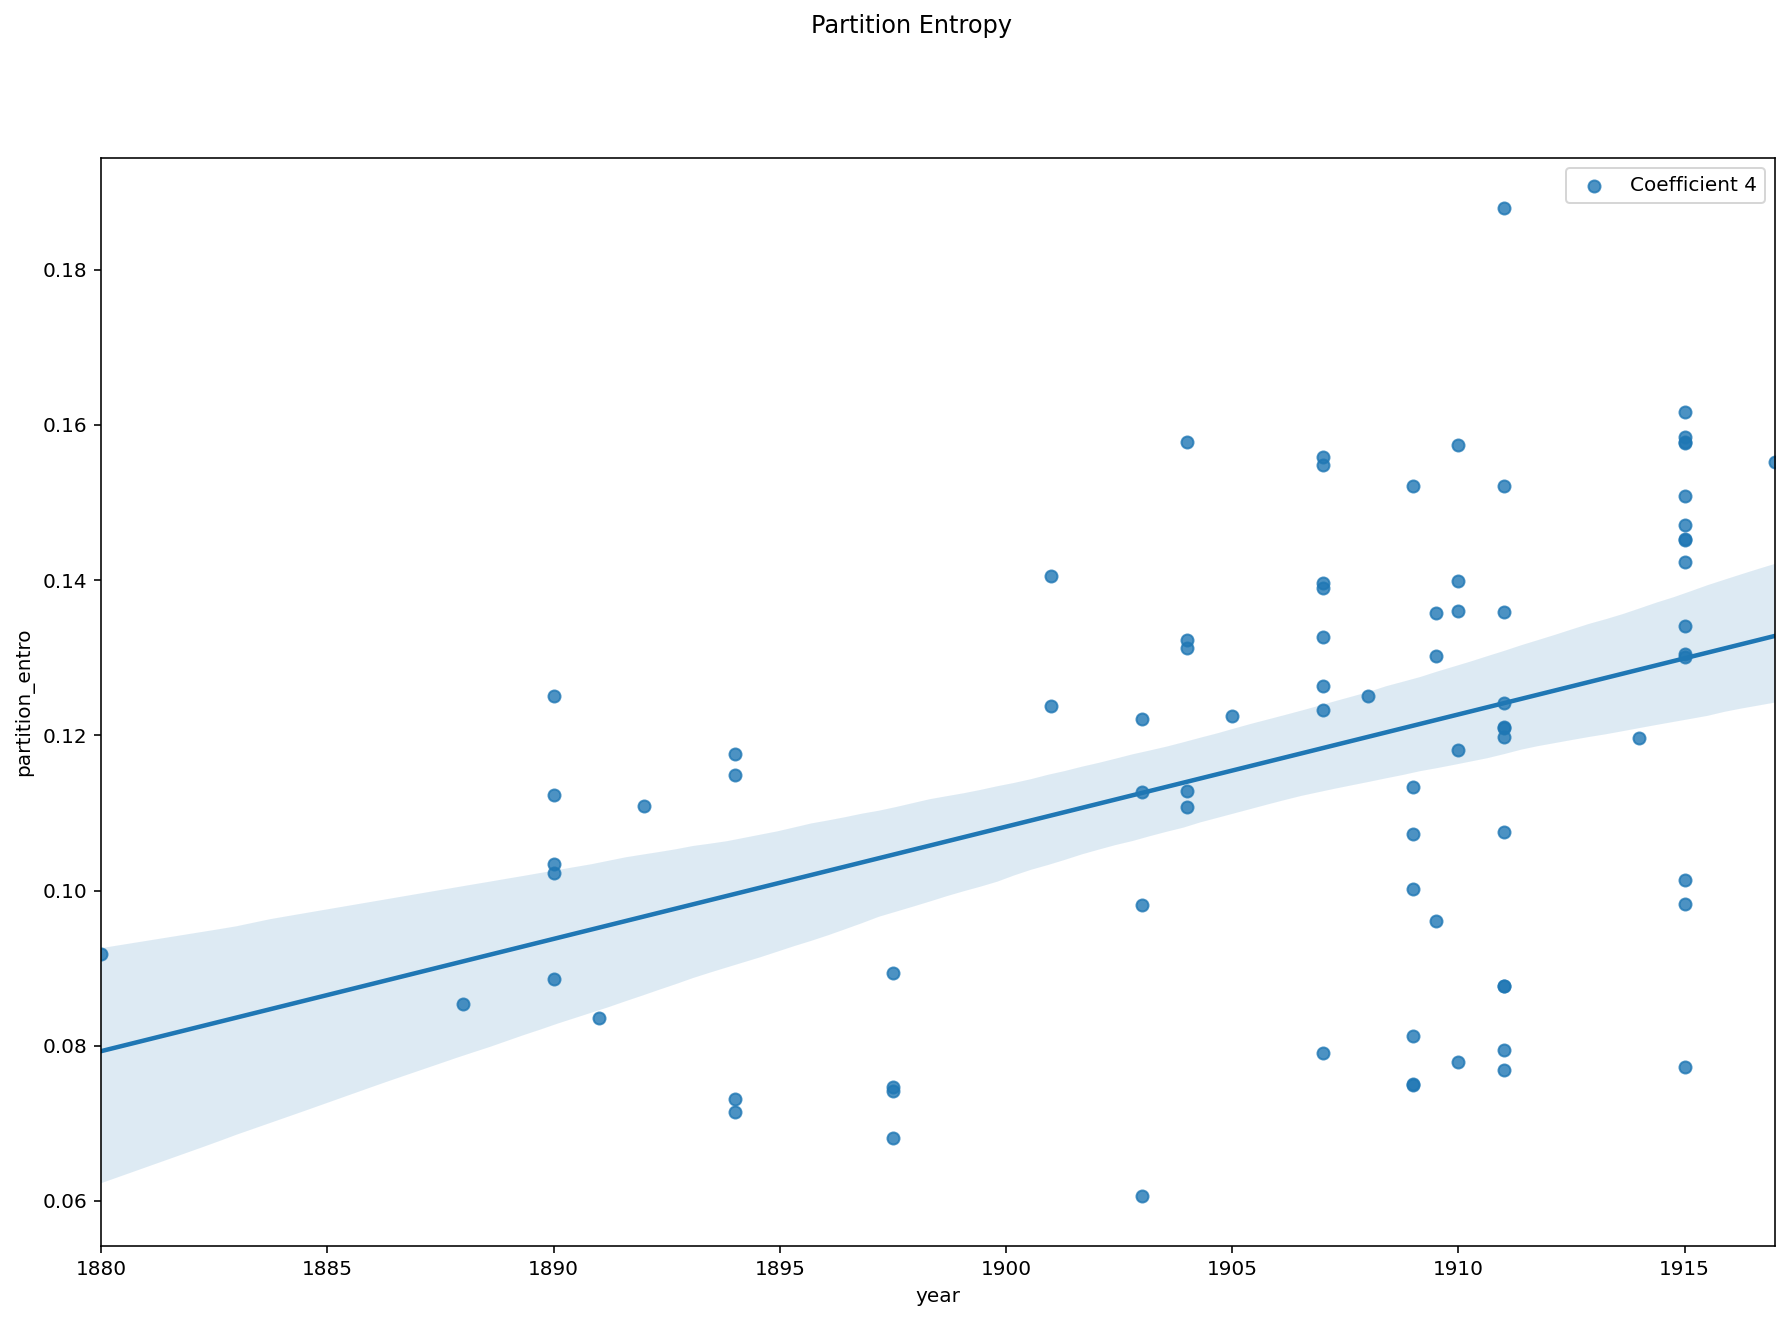

In [91]:
# takes quite long
cols = 'partition_entropy'
### add interaction year length
metadata_metrics = get_metric('partition_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, scatter=True, testing=True,
                              show_plot=True, save_name='partition_entropy', title='Partition Entropy', unified=True)
metadata_metrics.head(1)

In [113]:
import pandas as pd
metadata_metrics_ = metadata_metrics.reset_index()
metadata_metrics_['fname'] = metadata_metrics_['index']
all_cols = [col for col in list(metadata_metrics_.columns) if col not in ['fname', 'length_qb', 'year', 'last_mc']]
metadata_metrics_ = pd.melt(metadata_metrics_, id_vars=['fname', 'length_qb', 'year', 'last_mc'], value_vars=all_cols)    
metadata_metrics_.head()  

,fname,length_qb,year,last_mc,variable,value
0,l000_etude,284.0,1915.0,73,index,l000_etude
1,l000_soirs,92.0,1917.0,23,index,l000_soirs
2,l009_danse,184.0,1880.0,92,index,l009_danse
3,l066-01_arabesques_premiere,426.0,1888.0,107,index,l066-01_arabesques_premiere
4,l066-02_arabesques_deuxieme,440.0,1891.0,110,index,l066-02_arabesques_deuxieme


# Decreasing magnitude in height

The inverse coherence is the slope of the regression line that starts from the magnitude resonance in the summary wavescape at bottom of the wavescape and reaches the one at the top of the wavescape.

,length_qb,year,last_mc,variable,value,inverse_coherence
l000_etude,284.0,1915.0,73,percentage_resonances_entropy_1,-0.308288,-0.332314


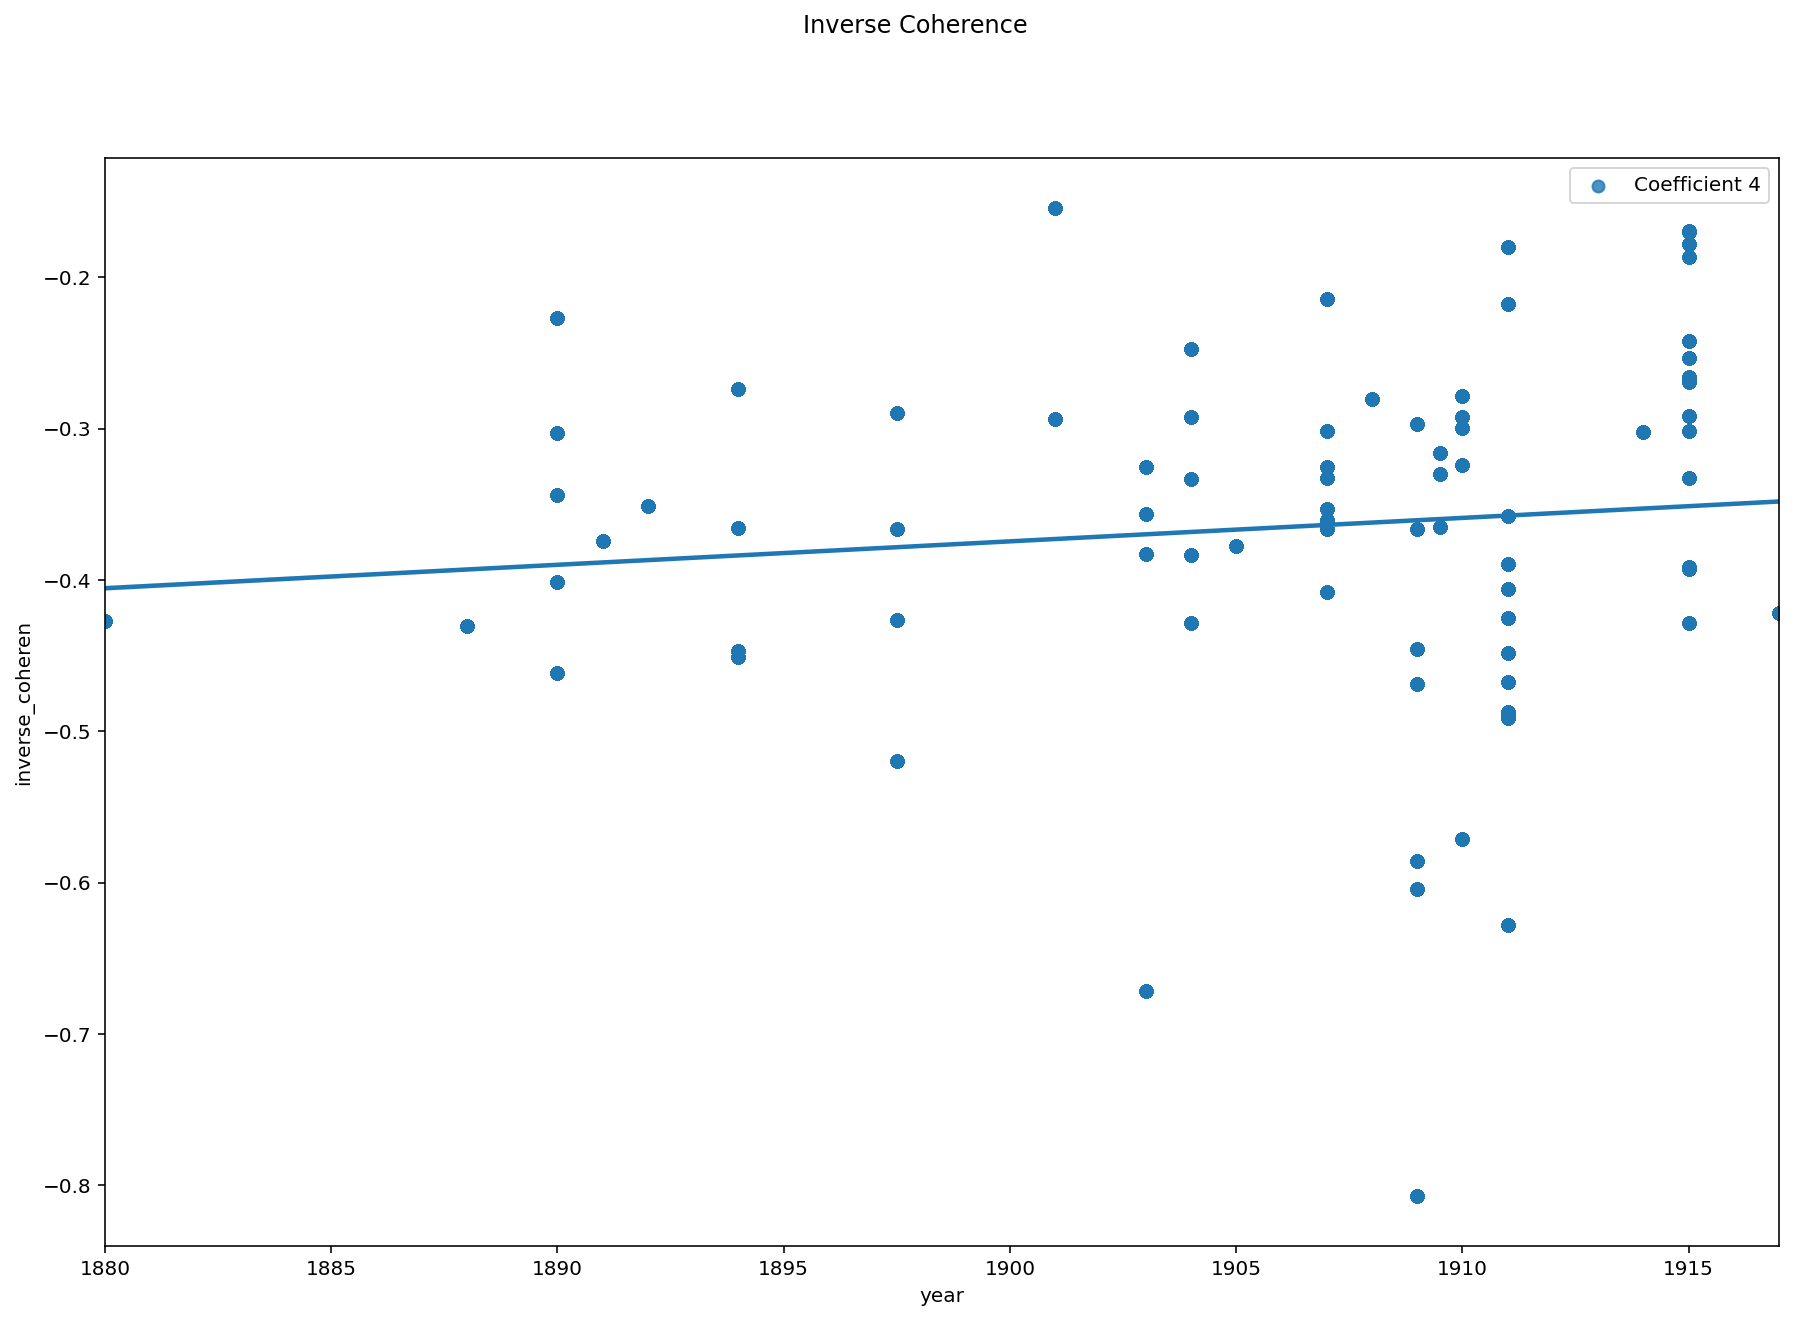

In [95]:
cols = 'inverse_coherence'
metadata_metrics = get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='inverse_coherence', title='Inverse Coherence', unified=True, scatter=True)
metadata_metrics.head(1)

In [96]:
metadata_metrics.head(1)

,length_qb,year,last_mc,variable,value,inverse_coherence
l000_etude,284.0,1915.0,73,percentage_resonances_entropy_1,-0.308288,-0.332314


In [84]:
metadata_metrics.to_csv('results/results.csv')

In [21]:
metadata_metrics.sort_values('inverse_coherence').tail()

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,n_onsets,TimeSig,KeySig,label_count,...,transcriber,typesetter,year,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute,years_ordinal,years_periods,inverse_coherence
l123-12_preludes_feux,MS3,100,100,206.25,206.25,515.73,2953,"1: 4/8, 30: 2/8, 31: 4/8, 32: 3/8, 33: 4/8, 38...","1: -1, 41: -5, 47: 0, 57: 3, 61: 0, 65: 6, 68:...",0,...,NaN,https://musescore.com/derek_john_benton,1911.0,264.724,46.746800,2.500509,116.890799,16,1,-0.180125
l136-06_etudes_huit,MS3,69,68,146.00,146.00,175.25,1389,"1: 3/4, 5: 2/4, 43: 3/4, 61: 2/4","1: -6, 13: -3, 29: 0, 33: -6",0,...,NaN,tunescribers.com,1915.0,93.133,94.059034,1.200342,112.903053,18,2,-0.178009
l136-05_etudes_octaves,MS3,121,121,181.50,181.50,595.83,2046,1: 3/8,"1: 4, 11: 0, 13: 4, 15: 0, 21: 4, 23: -3, 29: ...",0,...,NaN,tunescribers.com,1915.0,161.106,67.595248,3.282810,221.902350,18,2,-0.170029
l136-09_etudes_notes,MS3,85,84,336.00,336.00,734.62,2026,1: 4/4,"1: 1, 28: 0, 50: 1, 59: 4, 63: 0, 67: 1",0,...,NaN,tunescribers.com,1915.0,192.400,104.781705,2.186369,229.091476,18,2,-0.169365
l095-03_pour_toccata,MS3,266,266,532.00,532.00,1650.75,3563,1: 2/4,"1: 4, 78: 0, 198: 7, 206: 4, 228: 7",0,...,NaN,https://musescore.com/mil_not_sniw,1901.0,233.760,136.550308,3.102914,423.703799,7,1,-0.154054


In [26]:
max_mag = max_mags['l123-08_preludes_ondine']
#max_coeff = max_coeffs['l108_morceau']
np.polyfit((max_mag.shape[1] - np.arange(max_mag.shape[1]))/max_mag.shape[1], np.mean(max_mag, axis=0), 1)[0]

-0.6276457861741962

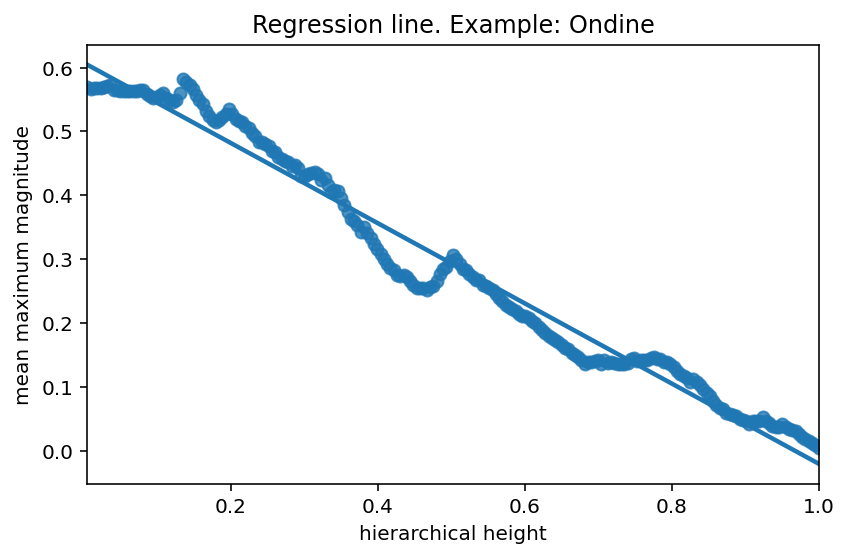

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.regplot(x=(max_mag.shape[1] - np.arange(max_mag.shape[1]))/max_mag.shape[1], y=np.mean(max_mag, axis=0), ci=False)
ax.set_title('Regression line. Example: Ondine')
ax.set_xlabel('hierarchical height')
ax.set_ylabel('mean maximum magnitude')

plt.tight_layout()
plt.savefig('figures/coherence.png')

plt.show()


In [25]:
metadata_metrics = get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=False, testing=True)

testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.351
Date:                Wed, 27 Jul 2022   Prob (F-statistic):            0.00662
Time:                        20:10:54   Log-Likelihood:                -111.14
No. Observations:                  82   AIC:                             228.3
Df Residuals:                      79   BIC:                             235.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.2776     25.743    

Storing the final metrics for future use:

In [28]:
metadata_metrics.reset_index().to_csv('normalized_coherence.csv')

In [56]:
metadata_metrics.reset_index().to_csv('metrics_new.csv')